In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from scipy.optimize import NonlinearConstraint
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
import optuna
import numpy as np
import optuna
import numpy as np
import base 
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from collections import deque

import base 
# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
import datetime
import pickle
# 机器学习库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler
# 优化相关库
from skopt import gp_minimize
from scipy.optimize import minimize

# 深度学习库
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 中文字体设置
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

# 其他路径设置
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")

# 自定义模块
import base 


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='原始输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
# df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='单SI_0.2_0.8') 
# print(df_sheet_yuansu.info())
# print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\新输入输出模式\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean_all') 

# print(df_sheet_params.info())
# print(df_sheet_params.columns)



In [ ]:
# 检查 DataFrame 中是否包含 NaN 值
def check_if_NaN(data):
    print(data.shape)
    contains_nan = data.isna().any().any()
    if contains_nan:
        print("数据包含 NaN 值")
    else:
        print("数据不包含 NaN 值")

        
check_if_NaN(df_sheet_yuansu)
check_if_NaN(df_sheet_params)


In [ ]:
df_sheet_params.columns


In [5]:
input_term =        ['富氧流量', '冷风流量', '热风压力', '热风温度']
# input_term =        ['富氧流量', '设定喷煤量', '热风压力', '热风温度']
output_term = ['铁水温度[MIT]', '铁水硅含量[SI]']
last_output_term = ['铁水温度[MIT]2', '铁水硅含量[SI]2']
time_term= '时间戳h'


In [ ]:
# 处理异常值

# 创建数据框副本以避免修改原始数据

df_sheet_X = df_sheet_params.copy()
df_sheet_X_process = df_sheet_X.copy()
df_sheet_Y = df_sheet_yuansu.copy()
df_sheet_Y_process = df_sheet_Y.copy()


def IQR_process(df_IQR, columns):
    df_IQR = df_IQR
    columns = columns

    print(columns)      # 获取数据框的所有列名
    outlier_indices = set()  # 用于存储异常值的行索引

    # 1. 分别处理每个变量
    for column in columns:
        # 计算描述性统计
        stats = df_IQR[column].describe()

        # 计算IQR（四分位距）以及上下须的范围
        Q1 = stats['25%']
        Q3 = stats['75%']
        IQR = Q3 - Q1
        lower_whisker = Q1 - 8 * IQR
        upper_whisker = Q3 + 8 * IQR
        # if column == '热风压力':
        #     lower_whisker = Q1 - 2 * IQR
        #     upper_whisker = Q3 + 1.5 * IQR

        # # 绘制箱线图
        # plt.figure(figsize=(8, 6))
        # sns.boxplot(data=df_IQR[column])
        # plt.title(f'Boxplot of {column}', fontproperties=font)
        # plt.xlabel('Feature', fontproperties=font)
        # plt.ylabel('Value', fontproperties=font)
        # plt.show()

        # 查找异常值的索引
        outliers = df_IQR[(df_IQR[column] < lower_whisker) | 
                            (df_IQR[column] > upper_whisker)].index
        outlier_indices.update(outliers)

        # # 打印统计信息和异常值范围
        # print(f"列: {column}")
        # print(f"第一四分位数 (Q1): {Q1}")
        # print(f"第三四分位数 (Q3): {Q3}")
        # print(f"下须 (lower whisker): {lower_whisker}")
        # print(f"上须 (upper whisker): {upper_whisker}")
        # print(f"找到的异常值索引: {list(outliers)}")

        
        # print(f"异常值数量: {len(outliers)}")
        # print(f"总数: {len(df_IQR[column])}")

        # print(f"异常值比例: {len(outliers)/len(df_IQR[column])}\n")

    # 2. 删除所有异常值
    df_cleaned = df_IQR.drop(index=outlier_indices)
    # 重新设置索引，使索引从 0 开始，并丢弃旧索引
    df_cleaned.reset_index(drop=True, inplace=True)
    # 输出处理后的数据框信息
    print(f"原始数据行数: {df_IQR.shape[0]}")
    print(f"删除异常值后的数据行数: {df_cleaned.shape[0]}")

    # 你可以继续对 df_cleaned 进行后续处理



    return df_cleaned


df_cleaned_X = IQR_process(df_sheet_X_process, input_term)
df_cleaned_Y = IQR_process(df_sheet_Y_process, output_term)

# print(np.max(df_cleaned_Y['铁水温度[MIT]']))
# print(np.min(df_cleaned_Y['铁水温度[MIT]']))
# print(np.max(df_cleaned_Y['铁水硅含量[SI]']))
# print(np.min(df_cleaned_Y['铁水硅含量[SI]']))


# 画出数据
def plot_subplot(data_x_yuan,data_y_yuan,data_x,data_y,column):
    plt.plot(data_x_yuan,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


    
plt.figure(figsize=(15, 4))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(   df_sheet_X[time_term].values,   df_sheet_X[column].values, 
                    df_cleaned_X[time_term].values, df_cleaned_X[column].values,
                    column                )
    
plt.figure(figsize=(15, 4))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(   df_sheet_Y[time_term].values,   df_sheet_Y[column].values, 
                    df_cleaned_Y[time_term].values, df_cleaned_Y[column].values,
                    column                )



In [ ]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_cleaned_Y.copy()
df_sheet_params_process = df_cleaned_X.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 2.5 * y.std()
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[3]])
# replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
# replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
# replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

# replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
# replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 4))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_cleaned_X[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 2))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_cleaned_Y[column].values,df_sheet_yuansu_process[column].values,column)




In [ ]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 400
start1 = 0
length2 = 400
start2 = 400


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 6))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)


In [ ]:
df_sheet_yuansu_process.describe(percentiles=[.10, .90])


In [22]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    # input_term[4]:   df_sheet_params_process[input_term[4]].values,
    # input_term[5]:   df_sheet_params_process[input_term[5]].values,
    # input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [ ]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每浓度的输出差：',(data3-data1))


In [16]:
isShuffle = True
isShuffle = False
time_steps = 2
test_size = 0.15
val_size = 0.15
train_size = 1-val_size-test_size


In [17]:
# 组合训练数据--拆分训练、测试集

# 定义时间步数和特征数

# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,index_fanwei):
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data))
    y = np.column_stack((y1_data, y2_data))

    X_modified = []
    y_modified = []
    
    for i in range(3,len(y1_data)):
        if i in index_fanwei:
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] <= yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            
            index = closest_10.index
            # print(index)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps + 1:
                print(i,yuansu_time,'errloss')
            else:

                # print(X[index, :])
                new_x_sample = np.concatenate([X[i, :] for i in index],axis=0)
                # print(new_x_sample)
                y_last = y[i-1, :]
                # print(y_last, 'y_last time : ',df_sheet_yuansu[time_term][i-1])
                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)
                # print(new_x_sample)
                y_sample = y[i, :]  
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
def symmetrical_moving_average(data, N):
    """
    使用对称的移动平均滤波，当前值由其自身及其前后的值决定。
    
    :param data: 输入的数据序列，一般为列表或者NumPy数组。
    :return: 经过滤波处理的数据序列。
    """
    filtered_data = []
    N = 9
    percent = 0.8
    # 遍历数据，从索引1开始到倒数第二个元素结束
    for i in range(1, len(data) - 1):
        # 计算当前值及其前后值的平均
        average = (data[i - 1]*(1-percent)/2 + data[i]*percent + data[i + 1]*(1-percent)/2)
        filtered_data.append(average)
    
    # 对于序列的第一个和最后一个元素，直接使用原始值
    # 或者可以使用其他边界处理策略
    filtered_data.insert(0, data[0])
    filtered_data.append(data[-1])
    
    return np.array(filtered_data)

# 示例数据
data = [2, 4, 6, 8, 10, 12, 14]
filtered_data = symmetrical_moving_average(data,9)
print(filtered_data)




In [ ]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]

# filter_windows = 2
# u1_data = symmetrical_moving_average(u1_data, filter_windows)
# u2_data = symmetrical_moving_average(u2_data, filter_windows)
# u3_data = symmetrical_moving_average(u3_data, filter_windows)
# u4_data = symmetrical_moving_average(u4_data, filter_windows)
# u5_data = symmetrical_moving_average(u5_data, filter_windows)
# u6_data = symmetrical_moving_average(u6_data, filter_windows)
# u7_data = symmetrical_moving_average(u7_data, filter_windows)
# y1_data = symmetrical_moving_average(y1_data, filter_windows)
# y2_data = symmetrical_moving_average(y2_data, filter_windows)

print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]

# filter_windows = 2
# u1_data = symmetrical_moving_average(u1_data, filter_windows)
# u2_data = symmetrical_moving_average(u2_data, filter_windows)
# u3_data = symmetrical_moving_average(u3_data, filter_windows)
# u4_data = symmetrical_moving_average(u4_data, filter_windows)
# u5_data = symmetrical_moving_average(u5_data, filter_windows)
# u6_data = symmetrical_moving_average(u6_data, filter_windows)
# u7_data = symmetrical_moving_average(u7_data, filter_windows)
# y1_data = symmetrical_moving_average(y1_data, filter_windows)
# y2_data = symmetrical_moving_average(y2_data, filter_windows)
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



In [ ]:
print('高炉模型数据')
X_1, X_2, X_3,\
y_1, y_2, y_3 = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=range(0, 7000, 1))


In [78]:
last_input_term = input_term


In [81]:
X_concat = np.concatenate((X_1, X_2, X_3), axis=0)
print(X_concat.shape)
y_concat = np.concatenate((y_1, y_2, y_3), axis=0)
print(y_concat.shape)
new_concat = np.concatenate((X_concat[1:,0:4], y_concat[1:,0:2], y_concat[:-1,0:2]), axis=1)

print(new_concat.shape)
print(X_concat[0:2,:])
print(y_concat[0:2,:])
print(new_concat[0:2,:])



data2_all = {
    input_term[0]: new_concat[1:,0],
    input_term[1]: new_concat[1:,1],
    input_term[2]: new_concat[1:,2],
    input_term[3]: new_concat[1:,3],
    last_input_term[0]: new_concat[:-1,0],
    last_input_term[1]: new_concat[:-1:,1],
    last_input_term[2]: new_concat[:-1:,2],
    last_input_term[3]: new_concat[:-1:,3],
    output_term[0]: new_concat[1:,4],
    output_term[1]: new_concat[1:,5],
    last_output_term[0]: new_concat[1:,6],
    last_output_term[1]: new_concat[1:,7]
}

# 将字典转换为 DataFrame
data2_all = pd.DataFrame(data2_all)

# 查看生成的 DataFrame
print(data2_all)


(6974, 10)
(6974, 2)
(6973, 8)
[[-0.68740046  0.64589665  0.13441168 -0.93058952 -0.74406038  0.35937037
   0.24226475 -0.90347834  0.88451258  0.35896029]
 [-0.71620173  0.80033425  0.29625311 -0.98768949 -0.68740046  0.64589665
   0.13441168 -0.93058952  0.81329022  0.27263639]]
[[0.81329022 0.27263639]
 [0.72786534 0.4377754 ]]
[[-0.71620173  0.80033425  0.29625311 -0.98768949  0.72786534  0.4377754
   0.81329022  0.27263639]
 [-0.78632029  0.82712562  0.11633031 -0.98671017  0.6795551   0.13955371
   0.72786534  0.4377754 ]]
          富氧流量      冷风流量      热风压力      热风温度  铁水温度[MIT]  铁水硅含量[SI]  \
0    -0.716202  0.800334  0.296253 -0.987689   0.679555   0.139554   
1    -0.786320  0.827126  0.116330 -0.986710   0.590282   0.063325   
2    -0.736134  0.800280  0.121451 -1.000000   0.415708   0.136370   
3    -0.671181  0.813190  0.146801 -0.997094   0.241135   0.141760   
4    -0.632521  0.826100  0.277829 -0.929773   0.858148  -0.051187   
...        ...       ...       ...       ... 

In [27]:
epoch_once_time = 50
ischuangxin = True
# ischuangxin = False
cengshu = 3


In [28]:
# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, if_chuangxin = False,gamma = 0.1):
        self.if_chuangxin = if_chuangxin
        super(MyNeuralNetwork, self).__init__()
        if cengshu == 3:    
            if self.if_chuangxin:            
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, hidden_size)
                self.fc4 = nn.Linear(hidden_size, output_size)
            else:
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, hidden_size)
                self.fc4 = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()
        elif cengshu == 2:  
            if self.if_chuangxin:            
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, output_size)
            else:
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()


    def forward(self, x0):
        if cengshu == 3:    
            if self.if_chuangxin:

                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = self.fc3(x2)
                x3 = self.relu(x3)

                x4 = x + x2 + x3
                output = self.fc4(x4)
            else:
                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = self.fc3(x2)
                x3 = self.relu(x3)

                output = self.fc4(x3)
        elif cengshu == 2:  
            if self.if_chuangxin:

                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = x + x2
                output = self.fc3(x3)
            else:
                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                output = self.fc3(x2)
        return output
        
        return output
    
    

    
    def custom_loss(self, y_true, y_pred):

        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse
    

    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    def model_update(self, 
                X_train, y_train, 
                epochs=1, batch_size=32, lr=0.001,ifprint = False):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            if(ifprint):print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}')
            
            
        return 0
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [29]:
# 建立高炉模型实例
input_size = 10  # 输入特征大小
hidden_size = 16  # 32
output_size = 2  # 输出大小
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyNeuralNetwork(input_size, 
                            hidden_size,
                            output_size,
                            ischuangxin,
                            gamma = 0.1)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


In [ ]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
input_term


In [ ]:
# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
input_term333 =       input_term
output_term333 = ['铁水温度MIT', '铁水硅含量[Si]']
time_term= '时间戳h'
print(input_term333)
print(output_term333)
input_term222 =        ['富氧流量/(m\u00b3/h)', '冷风流量/(m\u00b3/h)', '热风压力/kPa', '热风温度/℃']
output_term222 = ['铁水温度MIT/℃', '铁水硅含量[Si]/%']
time_term= '时间戳h'
print(input_term222)
print(output_term222)


In [33]:
ditem = -0.65


In [34]:
def double_control_train_test_result(scalers, output_term, y_test, y_pred_0, y_pred_1, y_test_2, y_pred_0_2, y_pred_1_2,ditem,a,b):
    y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
    y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
    y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

    output0 = y_test_0 - y_pred_0_inverse_transform
    output1 = y_test_1 - y_pred_1_inverse_transform

    plt.figure(figsize=(9, 8))
    
    
    ax = plt.subplot(4, 1, 1)
    plt.plot(y_test_0,'k', label="真实值")
    plt.plot(y_pred_0_inverse_transform,'r--', label="预测值")
    ax.legend(prop=font, loc='upper right', bbox_to_anchor=(a, b), ncol=4) 
    
    plt.ylabel(output_term222[0], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[0]} {output_term333[0]}建模效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('训练样本', fontproperties=font)  




    ax = plt.subplot(4, 1, 2)
    plt.plot(y_test_1,'k')
    plt.plot(y_pred_1_inverse_transform,'r--')
    plt.ylabel(output_term222[1], fontproperties=font) 

    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[1]} {output_term333[1]}建模效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    
    ax.set_xlabel('训练样本', fontproperties=font)  




    y_test_0 = scalers[output_term[0]].inverse_transform((y_test_2[:, 0]).reshape(-1, 1)).flatten()
    y_test_1 = scalers[output_term[1]].inverse_transform((y_test_2[:, 1]).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0_2).reshape(-1, 1)).flatten()
    y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1_2).reshape(-1, 1)).flatten()

    output0 = y_test_0 - y_pred_0_inverse_transform
    output1 = y_test_1 - y_pred_1_inverse_transform

    ax = plt.subplot(4, 1, 3)
    plt.plot(y_test_0,'k', label="真实值")
    plt.plot(y_pred_0_inverse_transform,'r--', label="预测值")
    plt.ylabel(output_term222[0], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[2]} {output_term333[0]}预测效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('测试样本', fontproperties=font)  



    ax = plt.subplot(4, 1, 4)
    plt.plot(y_test_1,'k')
    plt.plot(y_pred_1_inverse_transform,'r--')
    plt.ylabel(output_term222[1], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[3]} {output_term333[1]}预测效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('测试样本', fontproperties=font)  




    plt.subplots_adjust(hspace=0.6)  # 调整子图之间的垂直间距
    plt.tight_layout()  # 自动调整子图布局
    plt.show()



In [ ]:
# 高炉模型建模效果
y_train_pred_0,y_train_pred_1 = model_gaolu.my_predict(X_gaolu_train)
y_test_pred_0,y_test_pred_1 = model_gaolu.my_predict(X_gaolu_test)

double_control_train_test_result(scalers,  output_term,
                                        y_gaolu_train,  y_train_pred_0, y_train_pred_1,
                                        y_gaolu_test ,   y_test_pred_0,  y_test_pred_1,
                                        ditem = -0.65   ,a = 0.63, b = 0.38 )

# base.double_control_train_test_result(scalers,  output_term,
#                                         y_gaolu_train[:-1],  y_train_pred_0[1:], y_train_pred_1[1:],
#                                         y_gaolu_test[:-1] ,   y_test_pred_0[1:],  y_test_pred_1[1:])


In [36]:
# 创建预测模型实例
# 设置随机种子
torch.manual_seed(0)
model_predict = MyNeuralNetwork(input_size, hidden_size, output_size,ischuangxin)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


In [ ]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model_predict.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# 预测模型建模效果
y_train_pred_0,y_train_pred_1 = model_predict.my_predict(X_predict_train)


y_test_pred_0,y_test_pred_1 = model_predict.my_predict(X_predict_test)

double_control_train_test_result(scalers,  output_term,
                                        y_predict_train,  y_train_pred_0, y_train_pred_1,
                                        y_predict_test,   y_test_pred_0,  y_test_pred_1,
                                        ditem = -0.65   ,a = 0.31, b = 0.38 )


In [ ]:
base.gaolu_predict_raw(scalers,output_term,model_predict,model_gaolu,X_predict_test,y_predict_test)


In [ ]:
# 使用NumPy重新构建神经网络架构
class MyNeuralNetworkNumpy:
    def __init__(self, model, input_size, hidden_size, output_size,ifchuangxin):
        self.ifchuangxin = ifchuangxin
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        params = {name: param.detach().numpy() for name, param in model.state_dict().items()}
        if cengshu == 3:    
            self.weights_fc1 = params['fc1.weight']
            self.bias_fc1 = params['fc1.bias']
            self.weights_fc2 = params['fc2.weight']
            self.bias_fc2 = params['fc2.bias']
            self.weights_fc3 = params['fc3.weight']
            self.bias_fc3 = params['fc3.bias']
            self.weights_fc4 = params['fc4.weight']
            self.bias_fc4 = params['fc4.bias']
        elif cengshu == 2:  
            self.weights_fc1 = params['fc1.weight']
            self.bias_fc1 = params['fc1.bias']
            self.weights_fc2 = params['fc2.weight']
            self.bias_fc2 = params['fc2.bias']
            self.weights_fc3 = params['fc3.weight']
            self.bias_fc3 = params['fc3.bias']
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, x):
        if cengshu == 3:    
            if self.ifchuangxin:
                hidden1 = np.dot(x, self.weights_fc1.T) + self.bias_fc1
                hidden1 = self.relu(hidden1)

                hidden2 = np.dot(hidden1, self.weights_fc2.T) + self.bias_fc2
                hidden2 = self.relu(hidden2)

                hidden3 = np.dot(hidden2, self.weights_fc3.T) + self.bias_fc3
                hidden3 = self.relu(hidden3)

                hidden4 = hidden1 + hidden2 + hidden3
                output = np.dot(hidden4, self.weights_fc4.T) + self.bias_fc4

            else:
                hidden1 = np.dot(x, self.weights_fc1.T) + self.bias_fc1
                hidden1 = self.relu(hidden1)

                hidden2 = np.dot(hidden1, self.weights_fc2.T) + self.bias_fc2
                hidden2 = self.relu(hidden2)

                hidden3 = np.dot(hidden2, self.weights_fc3.T) + self.bias_fc3
                hidden3 = self.relu(hidden3)

                output = np.dot(hidden3, self.weights_fc4.T) + self.bias_fc4
        elif cengshu == 2:  
            if self.ifchuangxin:
                hidden1 = np.dot(x, self.weights_fc1.T) + self.bias_fc1
                hidden1 = self.relu(hidden1)

                hidden2 = np.dot(hidden1, self.weights_fc2.T) + self.bias_fc2
                hidden2 = self.relu(hidden2)

                hidden3 = hidden1 + hidden2
                output = np.dot(hidden3, self.weights_fc3.T) + self.bias_fc3
                # hidden2 = self.relu(hidden2)

                # hidden3 = np.concatenate([x, hidden1, hidden2], axis=1)  # 按列连接
                # output = np.dot(hidden3, self.weights_fc3.T) + self.bias_fc3

            else:
                hidden1 = np.dot(x, self.weights_fc1.T) + self.bias_fc1
                hidden1 = self.relu(hidden1)

                hidden2 = np.dot(hidden1, self.weights_fc2.T) + self.bias_fc2
                hidden2 = self.relu(hidden2)

                output = np.dot(hidden2, self.weights_fc3.T) + self.bias_fc3


            
        return output
    
    
    def my_predict(self, data_input):
        input = data_input  # 随机初始化一个输入序列
        output_prediction = model_numpy.forward(input)
        return output_prediction[:,0], output_prediction[:,1]

# 使用NumPy模型进行预测
model_numpy = MyNeuralNetworkNumpy(model_predict, input_size, hidden_size, output_size,ischuangxin)


y_pred_0, y_pred_1 = model_numpy.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test
model_temp = copy.deepcopy(model_predict)
base.double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


In [ ]:
的方式公司的r


GAN


In [42]:
# 绘制叠加的散点图矩阵。
def plot_scatter_matrix(X_df, X_df_normal_index_gaolu, figsize=(10, 8),font=font, save_path=None):
    """
    绘制叠加的散点图矩阵。

    参数:
    X_df_normal (DataFrame): 第一组数据。
    X_df_normal_index_gaolu (DataFrame): 第二组数据。
    font (FontProperties, optional): 字体属性，用于设置标签的字体。
    """
    # 设置颜色和标记
    color_left = 'blue'
    color_right = 'red'
    marker_left = '.'
    marker_right = '.'

    # 设置数据
    df_left = X_df  # 第一组数据
    df_right = X_df_normal_index_gaolu  # 第二组数据

    # 绘制叠加的散点图矩阵
    plt.figure(figsize = figsize)
    num_cols = len(df_left.columns)
    
    for i, col1 in enumerate(df_left.columns):
        for j, col2 in enumerate(df_left.columns):
            ax = plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            # print( i * num_cols + j + 1,col2,col1)
            if i != j:
                ax.scatter(df_left[col2], df_left[col1], color=color_left, alpha=0.5, marker=marker_left, label='Left Data' if i == 0 and j == 1 else "")
                ax.scatter(df_right[col2], df_right[col1], color=color_right, alpha=0.5, marker=marker_right, label='Right Data' if i == 0 and j == 1 else "")
                ax.set_xlim([-1, 1])
                ax.set_ylim([-1, 1])
            else:
                ax.hist(df_left[col1], bins=50, alpha=0.5, color=color_left)
                ax.hist(df_right[col1], bins=50, alpha=0.5, color=color_right)
                ax.set_xlim([-1, 1])

            if i == num_cols - 1:
                ax.set_xlabel(col2, fontproperties=font)
            if j == 0:
                ax.set_ylabel(col1, fontproperties=font)

    # # 添加图例
    # plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    # 手动添加图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.5, 1))

    # 添加标题并调整布局
    plt.suptitle('Overlaid Scatter Matrix of Features', y=1.02)
    plt.tight_layout()
    
    # 如果提供了保存路径，则保存图像
    if save_path:
        plt.savefig(save_path)
        plt.close()  # 关闭当前的图像，以节省内存
    else:
        plt.show()  # 否则显示图像



# 绘制叠加的散点图矩阵。
def plot_scatter_matrix_22222(X_df, X_df_normal_index_gaolu, figsize=(10, 8),font=font, save_path=None):
    """
    绘制叠加的散点图矩阵。

    参数:
    X_df_normal (DataFrame): 第一组数据。
    X_df_normal_index_gaolu (DataFrame): 第二组数据。
    font (FontProperties, optional): 字体属性，用于设置标签的字体。
    """
    # 设置颜色和标记
    color_left = 'blue'
    color_right = 'red'
    marker_left = '.'
    marker_right = '.'

    # 设置数据
    df_left = X_df  # 第一组数据
    df_right = X_df_normal_index_gaolu  # 第二组数据

    # 绘制叠加的散点图矩阵
    plt.figure(figsize = figsize)
    num_cols = len(df_left.columns)
    
    for i, col1 in enumerate(df_left.columns):
        for j, col2 in enumerate(df_left.columns):
            ax = plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            # print( i * num_cols + j + 1,col2,col1)
            if i != j:
                ax.scatter(df_left[col2], df_left[col1], color=color_left, alpha=0.5, marker=marker_left, label='Left Data' if i == 0 and j == 1 else "")
                ax.scatter(df_right[col2], df_right[col1], color=color_right, alpha=0.5, marker=marker_right, label='Right Data' if i == 0 and j == 1 else "")
          
            else:
                ax.hist(df_left[col1], bins=50, alpha=0.5, color=color_left)
                ax.hist(df_right[col1], bins=50, alpha=0.5, color=color_right)
                ax.set_xlim([-1, 1])

            if i == num_cols - 1:
                ax.set_xlabel(col2, fontproperties=font)
            if j == 0:
                ax.set_ylabel(col1, fontproperties=font)

    # # 添加图例
    # plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    # 手动添加图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.5, 1))

    # 添加标题并调整布局
    plt.suptitle('Overlaid Scatter Matrix of Features', y=1.02)
    plt.tight_layout()
    
    # 如果提供了保存路径，则保存图像
    if save_path:
        plt.savefig(save_path)
        plt.close()  # 关闭当前的图像，以节省内存
    else:
        plt.show()  # 否则显示图像







In [ ]:
# 绘制散点图矩阵
# 转换为DataFrame
print('高炉部分数据')


# 转换为DataFrame
print('全部数据')
X_df_normal = pd.DataFrame(normalized_data_dict, columns=input_term)
print(X_df_normal.shape)
# check_if_NaN(X_df_normal)
Y_df_normal = pd.DataFrame(normalized_data_dict, columns=output_term)
# check_if_NaN(Y_df_normal)


# # 绘制散点图矩阵
# plot_scatter_matrix(X_df_normal, X_df_normal.loc[index_gaolu], font=font, figsize=(10, 8))
# # # 绘制散点图矩阵
# plot_scatter_matrix(Y_df_normal, Y_df_normal.loc[index_gaolu], font=font, figsize=(5, 4))


In [ ]:
# GAN超参数  训练数据


# 将历史数据转换为 PyTorch 张量
# data_item = loaded_data_df_normal
# data_item = data_test

data = torch.tensor(data_item.values, dtype=torch.float32)
df_GAN = data_item
test_sample_num = data.shape[0]



z_dim = 4  # 随机噪声维度
data_dim = data.shape[1]  # 数据维度，4
learning_rate = 0.0002
num_epochs = 200
n_critic = 5  # 每次更新生成器前，更新 Critic 的次数

print_piture_d = 10

# 设置数据加载器
batch_size = 512
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)




In [ ]:
# W-GAN模型定义和训练
# WGAN的生成器
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# WGAN的Critic
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# 权重裁剪
def weight_clipping(critic, clip_value=0.01):
    for param in critic.parameters():
        param.data.clamp_(-clip_value, clip_value)

# WGAN训练
def train_wgan(generator, critic, data_loader, num_epochs, z_dim, clip_value, n_critic, optimizer_G, optimizer_C, output_dir):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for epoch in range(num_epochs):
        for real_data in data_loader:
            batch_size = real_data.size(0)

            # 更新 Critic
            for _ in range(n_critic):
                z = torch.randn(batch_size, z_dim)
                fake_data = generator(z)

                # 计算 Critic 的损失（Wasserstein 距离）
                real_output = critic(real_data)
                fake_output = critic(fake_data.detach())
                c_loss = -torch.mean(real_output) + torch.mean(fake_output)

                optimizer_C.zero_grad()
                c_loss.backward()
                optimizer_C.step()

                # 对 Critic 权重进行裁剪
                weight_clipping(critic, clip_value)

            # 更新生成器
            z = torch.randn(batch_size, z_dim)
            fake_data = generator(z)
            fake_output = critic(fake_data)
            g_loss = -torch.mean(fake_output)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        print(f"WGAN_training Epoch [{epoch}/{num_epochs}], c_loss: {c_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

        if epoch % print_piture_d == print_piture_d-1:
            # 生成一些数据
            z = torch.randn(test_sample_num, z_dim)
            generated_data = generator(z).detach().numpy()

            # 将生成的数据转换为 DataFrame
            generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

            # 获取当前时间
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            # 构建保存路径和文件名
            filename = f"{current_time}.png"
            save_path = os.path.join(output_dir, filename)

            # 可视化生成的数据分布（你可以实现自己的可视化函数）
            plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font, save_path=save_path)


In [ ]:
# 初始化WGAN  训练
wgan_generator = Generator(input_dim=z_dim, output_dim=data_dim)
wgan_critic = Critic(input_dim=data_dim)
# 初始化优化器
optimizer_G = optim.Adam(wgan_generator.parameters(), lr=learning_rate, betas=(0.2, 0.999))
optimizer_C = optim.Adam(wgan_critic.parameters(), lr=learning_rate, betas=(0.2, 0.999))

# 训练WGAN
train_wgan(wgan_generator, wgan_critic, data_loader, 
                num_epochs=num_epochs, z_dim=z_dim, clip_value=0.01, 
                n_critic = 5, 
                optimizer_G=optimizer_G, optimizer_C=optimizer_C, 
                output_dir = r"data\train_output_picture\WGAN_training_output2")





In [ ]:
# 保存模型参数
def save_model(generator, discriminator, output_dir, epoch):
        # 创建保存目录（如果不存在）
        os.makedirs(output_dir, exist_ok=True)

        # 定义文件名
        generator_filename = os.path.join(output_dir, f"generator.pth")
        discriminator_filename = os.path.join(output_dir, f"discriminator.pth")

        # 保存生成器的模型参数
        torch.save(generator.state_dict(), generator_filename)
        print(f"Generator model saved to {generator_filename}")

        # 保存判别器的模型参数
        torch.save(discriminator.state_dict(), discriminator_filename)
        print(f"Discriminator model saved to {discriminator_filename}")

save_model(wgan_generator, wgan_critic, 
        output_dir=r"data\model_params\wgan_model_2", 
        epoch=num_epochs)


In [ ]:
# WGAN的生成器   初始化   加载生成器参数  获取 PyTorch 模型参数  构建numpy版本  初始化numpy生成器

# 初始化生成器和判别器
wgan_generator_item = Generator(input_dim=z_dim, output_dim=data_dim)


# 加载生成器参数C:\Users\haokw\Documents\GitHub\gaolu\up2\data
generator_path = r"C:\Users\haokw\Documents\GitHub\gaolu\up2\旧框架\data\model_params\wgan_model_all_data\generator.pth"
# generator_path = r"C:\Users\haokw\Documents\GitHub\gaolu\up2\data\model_params\wgan_model_all_data\generator.pth"
wgan_generator_item.load_state_dict(torch.load(generator_path))
wgan_generator_item.eval()  # 切换到评估模式
print(f"Generator model loaded from {generator_path}")


# 假设 lsgan_generator_item 已经是训练好的模型
def extract_pytorch_params(model):
    params = {}
    for name, param in model.named_parameters():
        params[name] = param.data.numpy()
    return params
# 获取 PyTorch 模型参数
wgan_generator_item_params = extract_pytorch_params(wgan_generator_item)



# 构建numpy版本
class WGANGeneratorNumpy:
    def __init__(self, input_dim, output_dim, params):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 使用从 PyTorch 模型中提取的参数初始化
        self.W1 = params['model.0.weight'].T  # 转置以匹配 numpy 矩阵乘法
        self.b1 = params['model.0.bias']
        
        self.W2 = params['model.2.weight'].T
        self.b2 = params['model.2.bias']
        
        self.W3 = params['model.4.weight'].T
        self.b3 = params['model.4.bias']
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x):
        z1 = np.dot(x, self.W1) + self.b1
        a1 = self.relu(z1)
        
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.relu(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        output = self.tanh(z3)
        
        return output
    


# 初始化numpy生成器
wgan_generator_numpy = WGANGeneratorNumpy(z_dim, data_dim, wgan_generator_item_params)



print('参数已迁移')




In [ ]:
# LS-GAN模型定义和训练
class LSGANGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            # nn.ReLU(True),
            nn.Linear(128, 256),
            # nn.ReLU(True),
            nn.Linear(256, output_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# LSGAN的判别器
class LSGANDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(LSGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# LSGAN的损失函数
def generator_loss(fake_output):
    return torch.mean((fake_output - 1) ** 2)

def discriminator_loss(real_output, fake_output):
    real_loss = torch.mean((real_output - 1) ** 2)
    fake_loss = torch.mean(fake_output ** 2)
    return real_loss + fake_loss


# # 定义LSGAN损失函数
# def generator_loss(fake_output, generated_data, real_data):
#     # LS-GAN 原始损失
#     lsgan_loss = torch.mean((fake_output - 1) ** 2)
#     # 生成数据与真实数据的MSE匹配损失
#     mse_loss = torch.mean((generated_data - real_data) ** 2)
#     return lsgan_loss + mse_loss

# def discriminator_loss(real_output, fake_output):
#     real_loss = torch.mean((real_output - 1) ** 2)
#     fake_loss = torch.mean(fake_output ** 2)
#     return real_loss + fake_loss



# LSGAN训练
def train_lsgan(generator, discriminator, data_loader, num_epochs, z_dim, optimizer_G, optimizer_D, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for epoch in range(num_epochs):
        for real_data in data_loader:
            batch_size = real_data.size(0)

            # 生成数据
            z = torch.randn(batch_size, z_dim)
            fake_data = generator(z)

            # 判别器前向传播
            real_output = discriminator(real_data)
            fake_output = discriminator(fake_data.detach())

            # 计算判别器损失
            d_loss = discriminator_loss(real_output, fake_output)
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # 生成器前向传播
            fake_output = discriminator(fake_data)

            # 计算生成器损失
            # g_loss = generator_loss(fake_output, fake_data, real_data)
            g_loss = generator_loss(fake_output)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        print(f"LS-GAN_training Epoch [{epoch}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

        if epoch % print_piture_d == print_piture_d-1:
            # 生成数据test_sample_num
            z = torch.randn(test_sample_num, z_dim)
            generated_data = generator(z).detach().numpy()

            # 将生成的数据转换为 DataFrame
            generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

            # 获取当前时间
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

            # 构建保存路径和文件名
            filename = f"{current_time}_LSGAN_Epoch_{epoch+1}_D_loss_{d_loss.item():.4f}_G_loss_{g_loss.item():.4f}.png"
            save_path = os.path.join(output_dir, filename)

            # 可视化生成的数据分布（你可以实现自己的可视化函数）
            plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font, save_path=save_path)


In [ ]:
# 初始化LSGAN优化器  训练
lsgan_generator = LSGANGenerator(input_dim=z_dim, output_dim=data_dim)
lsgan_discriminator = LSGANDiscriminator(input_dim=data_dim)

optimizer_G = optim.Adam(lsgan_generator.parameters(), lr=learning_rate, betas=(0.2, 0.999))
optimizer_D = optim.Adam(lsgan_discriminator.parameters(), lr=learning_rate, betas=(0.2, 0.999))

# 使用WGAN生成的数据作为输入进行LSGAN训练
train_lsgan(lsgan_generator, lsgan_discriminator, data_loader, 
                num_epochs=num_epochs, z_dim=z_dim, 
                optimizer_G=optimizer_G, optimizer_D=optimizer_D, 
                output_dir = r"data\train_output_picture\LS-GAN_training_output2")


In [ ]:
# 保存模型参数
def save_model(generator, discriminator, output_dir, epoch):
        # 创建保存目录（如果不存在）
        os.makedirs(output_dir, exist_ok=True)

        # 定义文件名
        generator_filename = os.path.join(output_dir, f"generator.pth")
        discriminator_filename = os.path.join(output_dir, f"discriminator.pth")

        # 保存生成器的模型参数
        torch.save(generator.state_dict(), generator_filename)
        print(f"Generator model saved to {generator_filename}")

        # 保存判别器的模型参数
        torch.save(discriminator.state_dict(), discriminator_filename)
        print(f"Discriminator model saved to {discriminator_filename}")
save_model(lsgan_generator, lsgan_discriminator, 
        output_dir=r"data\model_params\lsgan_model", 
        epoch=num_epochs)


In [ ]:
# LSGAN的生成器   初始化   加载生成器参数  获取 PyTorch 模型参数  构建numpy版本  初始化numpy生成器

# 初始化生成器和判别器
lsgan_generator_item = LSGANGenerator(input_dim=z_dim, output_dim=data_dim)


# 加载生成器参数
generator_path = r"C:\Users\haokw\Documents\GitHub\gaolu\up2\旧框架\data\model_params\lsgan_model_all_data\generator.pth"
# generator_path = r"data\model_params\lsgan_model\generator.pth"
lsgan_generator_item.load_state_dict(torch.load(generator_path))
lsgan_generator_item.eval()  # 切换到评估模式
print(f"Generator model loaded from {generator_path}")


# 假设 lsgan_generator_item 已经是训练好的模型
def extract_pytorch_params(model):
    params = {}
    for name, param in model.named_parameters():
        params[name] = param.data.numpy()
    return params
# 获取 PyTorch 模型参数
lsgan_generator_item_params = extract_pytorch_params(lsgan_generator_item)


print(lsgan_generator_item_params)

# 构建numpy版本
class LSGANGeneratorNumpy:
    def __init__(self, input_dim, output_dim, params):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # 使用从 PyTorch 模型中提取的参数初始化
        self.W1 = params['model.0.weight'].T  # 转置以匹配 numpy 矩阵乘法
        self.b1 = params['model.0.bias']
        
        self.W2 = params['model.1.weight'].T
        self.b2 = params['model.1.bias']
        
        self.W3 = params['model.2.weight'].T
        self.b3 = params['model.2.bias']
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x):
        z1 = np.dot(x, self.W1) + self.b1
        # a1 = self.relu(z1)
        
        z2 = np.dot(z1, self.W2) + self.b2
        # a2 = self.relu(z2)
        
        output = np.dot(z2, self.W3) + self.b3
        # output = self.tanh(z3)
        
        return output
    

# 初始化numpy生成器
lsgan_generator_numpy = LSGANGeneratorNumpy(z_dim, data_dim, lsgan_generator_item_params)



print('参数已迁移')




In [ ]:
# generated_numpy = wgan_generator_numpy
generated_numpy = lsgan_generator_numpy

# 从文件中加载 scalers_X 和 scalers_Y
with open(r'C:\Users\haokw\Documents\GitHub\gaolu\up2\data\scalers\scalers_X_all_data.pkl', 'rb') as f:
    scalers_X = pickle.load(f)


print('scalers参数已迁移')






In [ ]:
def series2U_numpy_in_control(z, M, generator_numpy, scalers_X, scalers, input_term, isprint = True):

    if(isprint):print(z.shape)

    # 生成一些随机数据进行测试
    x =  z.reshape(M, z_dim)

    # 前向传播
    generated_data = generator_numpy.forward(x)

    if(isprint):print("Generated data shape:", generated_data.shape)
    if(isprint):print("Generated data:\n", generated_data)


    # 分别提取 U1, U2, U3, U4
    U1 = generated_data[:, 0]
    U2 = generated_data[:, 1]
    U3 = generated_data[:, 2]
    U4 = generated_data[:, 3]

    if(isprint):print("U1:", U1)
    if(isprint):print("U2:", U2)
    if(isprint):print("U3:", U3)
    if(isprint):print("U4:", U4)

    U1_inverse = scalers_X[input_term[0]].inverse_transform(U1.reshape(-1, 1)).flatten()
    U2_inverse = scalers_X[input_term[1]].inverse_transform(U2.reshape(-1, 1)).flatten()
    U3_inverse = scalers_X[input_term[2]].inverse_transform(U3.reshape(-1, 1)).flatten()
    U4_inverse = scalers_X[input_term[3]].inverse_transform(U4.reshape(-1, 1)).flatten()

    if(isprint):print("U1_inverse:", U1_inverse)
    if(isprint):print("U2_inverse:", U2_inverse)
    if(isprint):print("U3_inverse:", U3_inverse)
    if(isprint):print("U4_inverse:", U4_inverse)

    
    U1_inverse_trans = scalers[input_term[0]].transform(U1_inverse.reshape(-1, 1)).flatten()
    U2_inverse_trans = scalers[input_term[1]].transform(U2_inverse.reshape(-1, 1)).flatten()
    U3_inverse_trans = scalers[input_term[2]].transform(U3_inverse.reshape(-1, 1)).flatten()
    U4_inverse_trans = scalers[input_term[3]].transform(U4_inverse.reshape(-1, 1)).flatten()

    
    if(isprint):print("U1_inverse_trans:", U1_inverse_trans)
    if(isprint):print("U2_inverse_trans:", U2_inverse_trans)
    if(isprint):print("U3_inverse_trans:", U3_inverse_trans)
    if(isprint):print("U4_inverse_trans:", U4_inverse_trans)

    # 将 U1, U2, U3, U4 连接成一个序列
    sequence = np.concatenate((U1_inverse_trans, U2_inverse_trans, U3_inverse_trans, U4_inverse_trans))
    if(isprint):print("Connected sequence:", sequence)

    return sequence



In [ ]:
# 测试series2U_numpy_in_control生成
test_size_generated_data = 3
z = np.random.randn(z_dim * test_size_generated_data)
generated_data = series2U_numpy_in_control(z,test_size_generated_data,  generated_numpy,scalers_X, scalers, input_term, isprint=True)



In [ ]:
fd法国混凝土


In [55]:
iscontrol = True
# iscontrol = False
Times = 20*25*80

Times = 600

# 过度系数  0.1 越小过度越快
rou = 0.1
if_add_noise = 0
if_gaolu_is_predict = 0
if_update_model = True
maxlen = 50

ifGAN = False

scalers_X = scalers
# scalers_X = scalers_X


In [56]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,rou,20)


In [ ]:
20*40*80/278/20



In [ ]:
y_gaolu_train.shape


-50

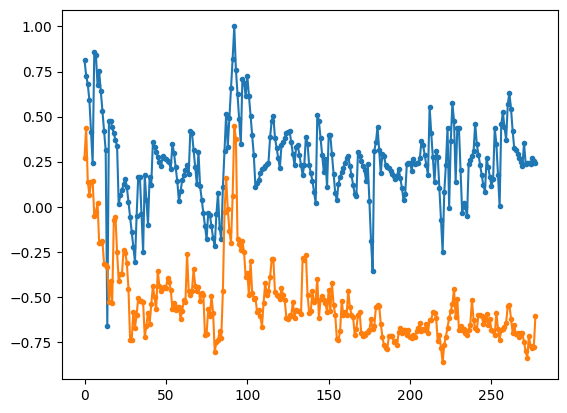

In [57]:
plt.plot(y_gaolu_train[0:380,0],'.-')
plt.plot(y_gaolu_train[0:380,1],'.-')
0.30-0.65
1485-1535


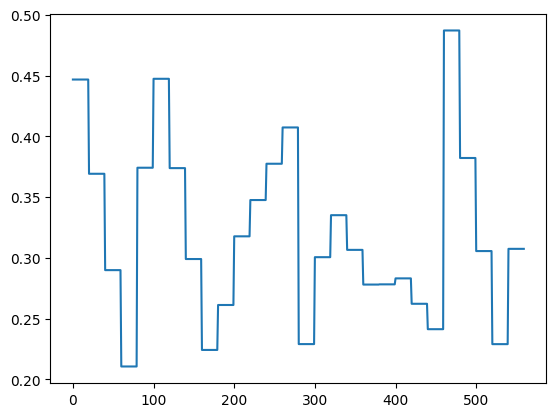

In [58]:
y_repeated = np.repeat(y_gaolu_test[10:40], repeats=20, axis=0)

plt.plot(y_repeated[20:580,0])


(600,)
(600,)
(600,)
(600,)
[1525.87591 1525.87591 1525.87591 1525.87591 1525.87591 1525.87591
 1525.87591 1525.87591 1525.87591 1525.87591 1525.87591 1525.87591
 1525.87591 1525.87591 1525.87591 1525.87591 1525.87591 1525.87591
 1525.87591 1525.87591 1534.90152 1534.90152 1534.90152 1534.90152
 1534.90152 1534.90152 1534.90152 1534.90152 1534.90152 1534.90152
 1534.90152 1534.90152 1534.90152 1534.90152 1534.90152 1534.90152
 1534.90152 1534.90152 1534.90152 1534.90152 1528.34397 1528.34397
 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397
 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397
 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397 1528.34397
 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951
 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951
 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951 1521.63951
 1521.63951 1521.63951 1514.93506 1514.93506 1514.93506 1514.93506
 1514.93506 1514.93506 1514.93506 

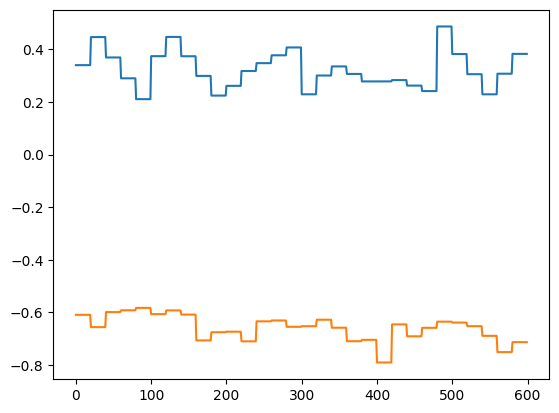

In [59]:
# # 生成期望数据

def generate_y_aim_data(Times):



    # # 打印原始形状
    # print("Original shape:", y_predict_test[:10].shape)

    # 重复每个数字10次
    y_repeated = np.repeat(y_gaolu_train[65:95], repeats=20, axis=0)
    y_repeated = np.repeat(y_gaolu_train[195:225], repeats=20, axis=0)
    # y_repeated = np.repeat(y_gaolu_train[0:278], repeats=20, axis=0)

    y_repeated = np.repeat(y_gaolu_test[10:40], repeats=20, axis=0)

    # # 打印新形状和内容
    # print("New shape:", y_repeated.shape)
    # print(y_repeated)




    if Times == 400:
        set_y1 = np.repeat(np.arange(1455, 1560, 5), 20)[10:410]
        set_y2 = np.repeat(np.arange(0.34, 0.76, 0.02), 20)[0:400]
        
    elif Times == 600:
        # y_repeated = np.repeat(y_gaolu_test[10:40], repeats=20, axis=0)
        set_y1 = y_repeated[:,0]
        set_y2 = y_repeated[:,1]
    elif Times == 278*20:
        
        y_repeated = np.repeat(y_gaolu_train[0:278], repeats=20, axis=0)
        set_y1 = y_repeated[:,0]
        set_y2 = y_repeated[:,1]

    elif Times == 3000:
        y_repeated = np.repeat(y_gaolu_train[120:270], repeats=20, axis=0)
        set_y1 = y_repeated[:,0]
        set_y2 = y_repeated[:,1]
    elif Times == 1000:
        y_repeated = np.repeat(y_gaolu_train[330:380], repeats=20, axis=0)
        set_y1 = y_repeated[:,0]
        set_y2 = y_repeated[:,1]

    # elif Times == 1000:
        # set_y1 = np.repeat(np.arange(1455, 1560, 5), 20)[10:410]
        # set_y2 = np.repeat(np.arange(0.34, 0.76, 0.02), 20)[0:400]
        # set_y1 = np.repeat(np.arange(1457.5, 1562.5, 5), 20)[10:410]
        # set_y2 = np.repeat(np.arange(0.35, 0.77, 0.02), 20)[0:400]




    elif Times == 20*25*80:
        
        # set_y1: 从 1485 到 1534 的整数，每个数字重复 20*35 次
        set_y1 = np.repeat(np.arange(1480, 1560,1), 25 * 20)

        # set_y2: 从 0.30 到 0.64 的小数（步长为 0.01），每个数字重复 20 次，再将整个数组重复 50 次
        set_y2 = np.repeat(np.arange(0.25, 0.50, 0.01), 20)
        set_y2 = np.tile(set_y2, 80)

    else:
        set_y1 = np.full(Times,1500)
        set_y2 = np.full(Times,0.45)

    





    # set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    # set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    set_y1_trans = set_y1
    set_y2_trans = set_y2
    set_y1 = scalers[output_term[0]].inverse_transform(set_y1_trans.reshape(-1,1)).flatten()
    set_y2 = scalers[output_term[1]].inverse_transform(set_y2_trans.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)
print(set_y1.shape)
print(set_y2.shape)
print(set_y1_trans.shape)
print(set_y2_trans.shape)
print(set_y1)
print(set_y2)
print(set_y1_trans)
print(set_y2_trans)
plt.plot(set_y1_trans)
plt.plot(set_y2_trans)


In [60]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, u3_data, u4_data, y1_data,y2_data, num_samples, P):
    nearest_index = np.abs(y1_data - (-0.5)).argmin()
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = nearest_index  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+3  ]
    u2   = u2_data[randint  :randint+3  ]
    u3   = u3_data[randint  :randint+3  ]
    u4   = u4_data[randint  :randint+3  ]

    y1   = y1_data[randint  :randint+3  ]
    y2   = y2_data[randint  :randint+3  ]
    k_data = np.concatenate((u1, u2, u3, u4, y1, y2), axis=0)
    print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [61]:
# # 生成高斯噪声,设置随机种子，以便结果可重现
# np.random.seed(42)
# gaussian_noise_SI = np.random.normal(0,d_yuansu*0.001,Times)
# gaussian_noise_TEMP = np.random.normal(0,d_temp*0.1,Times)
# # plt.subplot(2, 1, 1)
# # plt.plot(gaussian_noise_SI)
# # plt.subplot(2, 1, 2)
# # plt.plot(gaussian_noise_TEMP)


In [62]:
def update_model(model_predict,model_gaolu,x,gaolu_data_past_x,gaolu_data_past_y):
    y1_pred, y2_pred = model_gaolu.my_predict(x)
    y_label = np.column_stack((y1_pred, y2_pred))
    gaolu_data_past_x.append(x)
    gaolu_data_past_y.append(y_label)

    
    X_modified = np.array(gaolu_data_past_x)
    y_modified = np.array(gaolu_data_past_y)
    # print(X_modified)
    # print(y_modified)
    X = X_modified.reshape(X_modified.shape[0],X_modified.shape[2])
    Y = y_modified.reshape(y_modified.shape[0],y_modified.shape[2])
    # print(X_modified.shape)
    # print(y_modified.shape)
    if y_modified.shape[0]% 1 == 0:
        model_predict.model_update(X, Y,
                                epochs=10, 
                                batch_size=64,
                                lr = 0.002)
        # gaolu_data_past_x = []
        # gaolu_data_past_y = []

    return model_predict,model_gaolu,gaolu_data_past_x,gaolu_data_past_y


In [63]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint,ifGAN):

    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.01
    lamda2 =lamda1
    lamda3 =lamda1
    lamda4 =lamda1
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]

    y1   = k_data[12:15]
    y2   = k_data[15:18]

    
    # 获取猜测值[h U1 U2]

    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    if ifGAN:
        params = series2U_numpy_in_control(params,M, generated_numpy,
                                    scalers_X, scalers,
                                    input_term, isprint=False)
    U1, U2, U3, U4  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M]
    
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    if isprint:
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(y1.round(4))    
        print(y2.round(4))
        print('开始预测')

    y1_k = y1[2]
    y2_k = y2[2]





    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):   # j = 0
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k, y2_m_k = model_numpy.my_predict(x)
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k
        if isprint:
            print(j,'mode = 0')
            print(x.round(4))
            print(y1_k.round(4),y2_k.round(4))
            print(y1_m_k.round(4),y2_m_k.round(4))

    # 对控制时刻进行预测-----M次
    for j in range(1,M+1):  # j = 1,2
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = model_numpy.my_predict(x)
        y1[j+2] = y1_k_j.item()
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 1')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(u5.round(4))
            print(u6.round(4))
            print(u7.round(4))
            print(y1.round(4))    
            print(y2.round(4))

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):  #j = 3,4
        x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                                u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                                y1[j+1],y2[j+1]))
        # x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j, y2_k_j = model_numpy.my_predict(x)
        y1[j+2] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+2] = y2_k_j.item()
        if isprint:
            print(j,'mode = 2')
            print(x.round(4))
            print(y1_k_j.round(4),y2_k_j.round(4))
            print('更新后:')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(y1.round(4))    
            print(y2.round(4))



    k_data2 = np.concatenate((u1[1:4],u2[1:4],u3[1:4],u4[1:4],y1[1:4],y2[1:4]),axis=0)
    if isprint:
        print('更新k_data')
        print(k_data2.round(4))


    #获取参考轨迹
    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,rou,P+1)
    y1_r = y1_r_aim[1:] 


    y2_r_aim  = get_yr(y2_aim,y2_k,rou,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[3:]
    y2_M_k = y2[3:]
    if isprint==1:
        print('反馈补偿:')
        print('y1_k',y1_k.round(4))  
        print('y1_m_k',y1_m_k.round(4))    
        print('h*E1_k',(h1*E1_k).round(4)) 
        print('y2_k',y2_k.round(4))  
        print('y2_m_k',y2_m_k.round(4))   
        print('h*E2_k',(h2*E2_k).round(4))

        print('temp:')
        print('y1_aim',y1_aim.round(4))
        print('y1_r_aim',y1_r_aim.round(4))
        print('y1_r',y1_r.round(4))
        print('y1_M_k',y1_M_k.round(4))
        print('y1_M_k+h1*E1_k',(y1_M_k+h1*E1_k).round(4))

        print('Si_percent:')
        print('y2_aim',y2_aim.round(4))
        print('y2_r_aim',y2_r_aim.round(4))
        print('y2_r',y2_r.round(4))
        print('y2_M_k',y2_M_k.round(4))
        print('y2_M_k+h2*E2_k',(y2_M_k+h2*E2_k).round(4))

        print('u:')
        print(u1[2:].round(4))
        print(u2[2:].round(4))
        print(u3[2:].round(4))
        print(u4[2:].round(4))
        
    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙


    y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    u1_power = lamda1*np.sum((np.diff(u1[2:]))**2)
    u2_power = lamda2*np.sum((np.diff(u2[2:]))**2)
    u3_power = lamda3*np.sum((np.diff(u3[2:]))**2)
    u4_power = lamda4*np.sum((np.diff(u4[2:]))**2)

    # y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    # y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    # u1_power = lamda1*np.sum((np.fabs(np.diff(u1))))
    # u2_power = lamda2*np.sum((np.fabs(np.diff(u2))))
    # u3_power = lamda3*np.sum((np.fabs(np.diff(u3))))
    # u4_power = lamda4*np.sum((np.fabs(np.diff(u4))))
    # u5_power = lamda2*np.sum((np.fabs(np.diff(u5))))
    # u6_power = lamda3*np.sum((np.fabs(np.diff(u6))))
    # u7_power = lamda4*np.sum((np.fabs(np.diff(u7))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))



    return mse , k_data2, E1_k*h1,  E2_k*h2
    # return mse , k_data2, E1_k*h1


In [64]:
from shapely.geometry import Polygon, box
from shapely.geometry import Point


In [65]:
model_predict = copy.deepcopy(model_temp)
for name, params in model_predict.named_parameters():
    print(name, params.data.numpy())


fc1.weight [[-0.00236753  0.16963837 -0.26026973 -0.23272435 -0.1217965   0.08479881
  -0.00626549  0.25073364 -0.02806333  0.08367783]
 [ 0.01135924 -0.12590805 -0.26728085 -0.09139614 -0.0156107   0.04894404
   0.14942323  0.30365494 -0.43897954 -0.22414841]
 [ 0.08977427  0.23754363 -0.08984242  0.21147828 -0.07592119  0.00869517
   0.26142138 -0.31843314 -0.21161541 -0.05496974]
 [-0.12326556  0.27322105 -0.2049724  -0.14557004 -0.2209295  -0.2961666
  -0.18459494  0.27182874  0.14110664  0.1532669 ]
 [ 0.01663092 -0.16212475  0.05350089 -0.2952602  -0.22849551 -0.1630249
   0.19952008  0.18541107 -0.14024544 -0.01141027]
 [ 0.23279737  0.34261984  0.15425856  0.07465927  0.24137026 -0.1563552
   0.08547684 -0.21371299 -0.19561681 -0.2006839 ]
 [ 0.11882119  0.10103115 -0.21251436  0.07057866  0.14932911 -0.06582778
  -0.0131689   0.04823504  0.17023274  0.32746238]
 [-0.20595181 -0.11548318  0.14186361  0.31005678  0.3144338   0.30163386
   0.07697946 -0.22703288 -0.05167529 -0.25

In [66]:
# # 选择要绘制的多边形
# key = ('冷风流量', '热风温度')

# # 确保 expanded_hulls_data 中的值是 Polygon 对象的列表
# polygons = expanded_hulls_data[key]

# # 创建正方形边界（范围 [-1, 1]）
# boundary_box = box(0.5, 0.5, 1, 1)

# # 创建裁剪后的多边形
# clipped_polygons = [polygon.intersection(boundary_box) for polygon in polygons if not polygon.intersection(boundary_box).is_empty]

# x_hull, y_hull = polygons[0].exterior.xy
# plt.fill(x_hull, y_hull, alpha=0.3, edgecolor='black')
# x_hull, y_hull = clipped_polygons[0].exterior.xy
# plt.fill(x_hull, y_hull, alpha=0.3, edgecolor='black')
# plt.xlim([-1,1])
# plt.ylim([-1,1])


In [67]:
penalty_weight = 1.0


In [92]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 3  # 预测时域长度  3
M = 3  # 4
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, u3_data, u4_data,
                        y1_data, y2_data, num_samples, P)

model_predict = copy.deepcopy(model_temp)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_state = []
# 初始化一个最大长度为10的deque
gaolu_data_past_x = deque(maxlen=maxlen)
gaolu_data_past_y = deque(maxlen=maxlen)







# # 选择要绘制的多边形
# key = ('冷风流量', '热风温度')

# # 确保 expanded_hulls_data 中的值是 Polygon 对象的列表
# polygons = expanded_hulls_data[key]

# # 创建正方形边界（范围 [-1, 1]）
# boundary_box = box(-1, -1, 1, 0)

# # 创建裁剪后的多边形
# clipped_polygons = [polygon.intersection(boundary_box) for polygon in polygons if not polygon.intersection(boundary_box).is_empty]






# MPC控制循环4010
for k in range(Times):
    if iscontrol == False:
        break

    print(f"这是对第{k}时刻的最优U1、U2输入求解")


    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0,ifGAN = ifGAN) 
        return mse 
        # return mse



    # 初始猜测值[h U1 U2]   定义参数的上下限    设置退出条件
    if ifGAN:
        params = np.random.randn(z_dim * M)
        bounds = [(-max_control, max_control) for _ in range(z_dim * M)]
    else:
        params = np.concatenate([np.ones(M)*0.9, np.ones(M)*0.9,np.ones(M)*0.9, np.ones(M)*0.9])
        # print(params)
        # bounds = [(-max_control, max_control) for _ in range(4 * M)]
        # ['富氧流量', '冷风流量', '热风压力', '热风温度']
        # bounds =    [(0.4, 1) for _ in range(M)] + \
        #             [(0.7, 1) for _ in range(M)] + \
        #             [(0.8, 1) for _ in range(M)] + \
        #             [(0.5, 1) for _ in range(M)]


        # bounds = [(-max_control, max_control) for _ in range(M)] + \
        #         [(-max_control, max_control) for _ in range(M)] + \
        #         [(-max_control, max_control) for _ in range(M)] + \
        #         [(-max_control, max_control) for _ in range(M)]


        # new_data = np.column_stack([set_y1_trans[k],set_y1_trans[k]]).astype(np.float32)


        
        if k == 0:
            new_data = np.column_stack([set_y1_trans[k],set_y2_trans[k],0,0,0,0])
        else:
            new_data = np.column_stack([set_y1_trans[k],set_y2_trans[k],all_pred_u1[-1],all_pred_u2[-1],all_pred_u3[-1],all_pred_u4[-1]])
        # print(new_data.shape)
        # print(type(new_data))
        
        label = kmeans.predict(new_data)

        print(label)
        all_state.append(label)
        # print(input_term_limits[label[0]])
        # print(input_term_limits[label[0]][input_term[0]][0])
        # print(input_term_limits[label[0]][input_term[1]])
        # print(input_term_limits[label[0]][input_term[2]])
        # print(input_term_limits[label[0]][input_term[3]])



        bounds =    [(input_term_limits[label[0]][input_term[0]][0], input_term_limits[label[0]][input_term[0]][1]) for _ in range(M)] + \
                    [(input_term_limits[label[0]][input_term[1]][0], input_term_limits[label[0]][input_term[1]][1]) for _ in range(M)] + \
                    [(input_term_limits[label[0]][input_term[2]][0], input_term_limits[label[0]][input_term[2]][1]) for _ in range(M)] + \
                    [(input_term_limits[label[0]][input_term[3]][0], input_term_limits[label[0]][input_term[3]][1]) for _ in range(M)]
        



    # # 创建约束函数
    # def in_polygon_constraint(params):
    #     U1, U2, U3, U4 = params[0:M], params[M:2*M], params[2*M:3*M], params[3*M:4*M]
    #     # if k==0:print('44565')
    #     # 遍历所有点 (U2[i], U4[i])
    #     for x, y in zip(U2, U4):
    #         point = Point(x, y)
    #         # 检查点是否在任意裁剪的多边形内
    #         if not any(point.within(poly) for poly in clipped_polygons):
    #             return -1  # 如果任何点不在多边形内，返回负值表示不满足约束
    #     return 0  # 所有点都在多边形内，约束满足



    # # 添加非线性约束
    # constraints = [{'type': 'ineq', 'fun': in_polygon_constraint}]

    options = {
        'maxiter': 1000,      # 最大迭代次数
        'disp': True,         # 显示详细的优化过程信息
        'factr': 1e-20,       # 调整收敛精度（降低收敛阈值）
    }

    # 进行优化
    result = minimize(objective_function, 
                    params, 
                    method='COBYLA', 
                    args=k_data,
                    options=options,
                    # constraints=constraints,
                    bounds=bounds)  # 添加约束条件




    if ifGAN:
        result_u = series2U_numpy_in_control(np.array(params),M, generated_numpy,
                                            scalers_X, scalers,
                                            input_term, isprint=False)
        U1, U2, U3, U4 =    result_u[0:M], result_u[M:2*M], \
                            result_u[2*M:3*M], result_u[3*M:4*M]
    else:
        result_u = result.x
        U1, U2, U3, U4 =    result_u[0:M], result_u[M:2*M], \
                            result_u[2*M:3*M], result_u[3*M:4*M]





# ['富氧流量', '冷风流量', '热风压力', '热风温度']
    u1   = k_data[0:3]
    u2   = k_data[3:6]
    u3   = k_data[6:9]
    u4   = k_data[9:12]

    y1   = k_data[12:15]
    y2   = k_data[15:18]
    u1   = np.concatenate((u1,U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((u2,U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((u3,U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((u4,U4,U4[-1]*np.ones(P-M)))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))




    # for x, y in zip(U2, U4):
    #     point = Point(x, y)
    #     if any(point.within(poly) for poly in clipped_polygons):
    #         print(f'Point ({x}, {y}) is within the polygons.')
    #     else:
    #         print(f'Point ({x}, {y}) is outside the polygons.')




    # 将控制序列第一个数作用于高炉
    j = 1
    x = np.column_stack((   u1[j+2],u2[j+2],u3[j+2],u4[j+2],
                            u1[j+1],u2[j+1],u3[j+1],u4[j+1],
                            y1[j+1],y2[j+1]))
    # x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred0, y2_pred0 = model_predict.my_predict(x)
    if if_gaolu_is_predict:
        y1_pred, y2_pred = model_predict.my_predict(x)
        if if_add_noise:
            # y1_pred = y1_pred+gaussian_noise_TEMP[k].item()
            # y2_pred = y2_pred+gaussian_noise_SI[k].item()
            y1_pred = y1_pred
            y2_pred = y2_pred
    else:
        y1_pred, y2_pred = model_gaolu.my_predict(x)
        if if_update_model:
            # if (np.fabs(y2_pred-y2_pred0)<1.5*d_yuansu) & (np.fabs(y1_pred-y1_pred0)<3*d_temp):
            #     print('sdgsdegerwh')
            model_predict,model_gaolu,gaolu_data_past_x,gaolu_data_past_y = update_model(model_predict,model_gaolu,x,gaolu_data_past_x,gaolu_data_past_y)
            # 使用NumPy模型进行预测
            model_numpy = MyNeuralNetworkNumpy(model_predict, input_size, hidden_size, output_size,ischuangxin)



    # # 更新k_data
    
    if ifGAN:
        params = result.x
    else:
        params = np.concatenate((U1, U2, U3, U4),axis=0)


    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=np.array(params),
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0,ifGAN = ifGAN)


    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),(set_y1_trans[k]-y1_pred).round(4)/d_temp,\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),((set_y2_trans[k]-y2_pred).round(4)/d_yuansu)*100,\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))



    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    k_data2[14] = y1_pred.item()
    k_data2[17] = y2_pred.item()
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


579
(18,)
这是对第0时刻的最优U1、U2输入求解
[9]
1设定 0.34 预测 [0.1437] 高炉 [0.249] 高炉与设定误差 [0.091] [7.69877638] 模型误差 [-0.1053] 校正值 [-0.305]
2设定 -0.6094 预测 [-0.2755] 高炉 [-0.2306] 高炉与设定误差 [-0.3788] [-34.85925983] 模型误差 [-0.0449] 校正值 [0.2331]
这是对第1时刻的最优U1、U2输入求解
[9]
1设定 0.34 预测 [0.4961] 高炉 [0.552] 高炉与设定误差 [-0.212] [-17.93561107] 模型误差 [-0.056] 校正值 [0.0121]
2设定 -0.6094 预测 [-0.4778] 高炉 [-0.564] 高炉与设定误差 [-0.0454] [-4.1779578] 模型误差 [0.0862] 校正值 [-0.0341]
这是对第2时刻的最优U1、U2输入求解
[5]
1设定 0.34 预测 [0.4436] 高炉 [0.4655] 高炉与设定误差 [-0.1255] [-10.61754293] 模型误差 [-0.0219] 校正值 [0.0123]
2设定 -0.6094 预测 [-0.4947] 高炉 [-0.5269] 高炉与设定误差 [-0.0825] [-7.59210405] 模型误差 [0.0322] 校正值 [0.0071]
这是对第3时刻的最优U1、U2输入求解
[5]
1设定 0.34 预测 [0.4565] 高炉 [0.4876] 高炉与设定误差 [-0.1476] [-12.48724593] 模型误差 [-0.0311] 校正值 [-0.0042]
2设定 -0.6094 预测 [-0.5281] 高炉 [-0.559] 高炉与设定误差 [-0.0504] [-4.63808521] 模型误差 [0.0309] 校正值 [0.0045]
这是对第4时刻的最优U1、U2输入求解
[4]
1设定 0.34 预测 [0.516] 高炉 [0.461] 高炉与设定误差 [-0.121] [-10.23683468] 模型误差 [0.055] 校正值 [0.0305]
2设定 -0.6094 预测 [-0.5695]

In [94]:
np.max(np.array(all_pred_u1+all_pred_u2+all_pred_u3+all_pred_u4))


1.0000428063664264

In [61]:
# if iscontrol:
#     y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
#     y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)).flatten()
    
#     startt = 0
#     endd = Times
    
#     plt.figure(figsize=(7, 6))
#     plt.subplot(3, 1, 1)
#     plt.plot(set_y1[startt:endd],'r', label='设定值')
#     plt.plot(y1_pred_inverse_transform[startt:endd],'b', label='实际值')
#     plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
#     plt.grid(linestyle='--', alpha=0.7, color='gray')
#     plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
#     plt.legend(prop=font)
#     plt.title(f"模型:MLP 训练次数:{epoch_sum_gaolu} 隐含层数:{3} 改进:{ischuangxin} 动态更新:{if_update_model} P:{P} M:{M} ", fontproperties=font)

#     plt.subplot(3, 1, 2)
#     plt.plot(set_y2[startt:endd],'r')
#     plt.plot(y2_pred_inverse_transform[startt:endd],'b')
#     plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#     plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
#     plt.grid(linestyle='--', alpha=0.7, color='gray')


#     plt.subplot(3, 1, 3)
#     plt.plot(all_pred_u1,'r', label='富氧流量')
#     plt.plot(all_pred_u2,'g', label='冷风流量')
#     plt.plot(all_pred_u3,'b', label='热风压力')
#     plt.plot(all_pred_u4,'k', label='热风温度')
#     plt.legend(prop=font)

#             # ['富氧流量', '冷风流量', '热风压力', '热风温度']



In [89]:
# startt = 20
# endd = 340
# startt = 100
# endd = 300

# startt = 3700
# endd = startt+540
# startt = 840
# endd = startt+280
# startt = 840
# endd = startt+280
# startt = 2500
# endd = startt+180


startt = 0
endd = startt+600


# startt = 0
# endd = 160
# # endd = len(all_pred_y1)


上线分别是：[20073.68245125    35.6441052 ]、[33.63937862 26.80235557]、[0.43208747 0.34024956]、[1220.02980501  834.4521309 ]
平均误差 0.7434
平均误差 0.0054


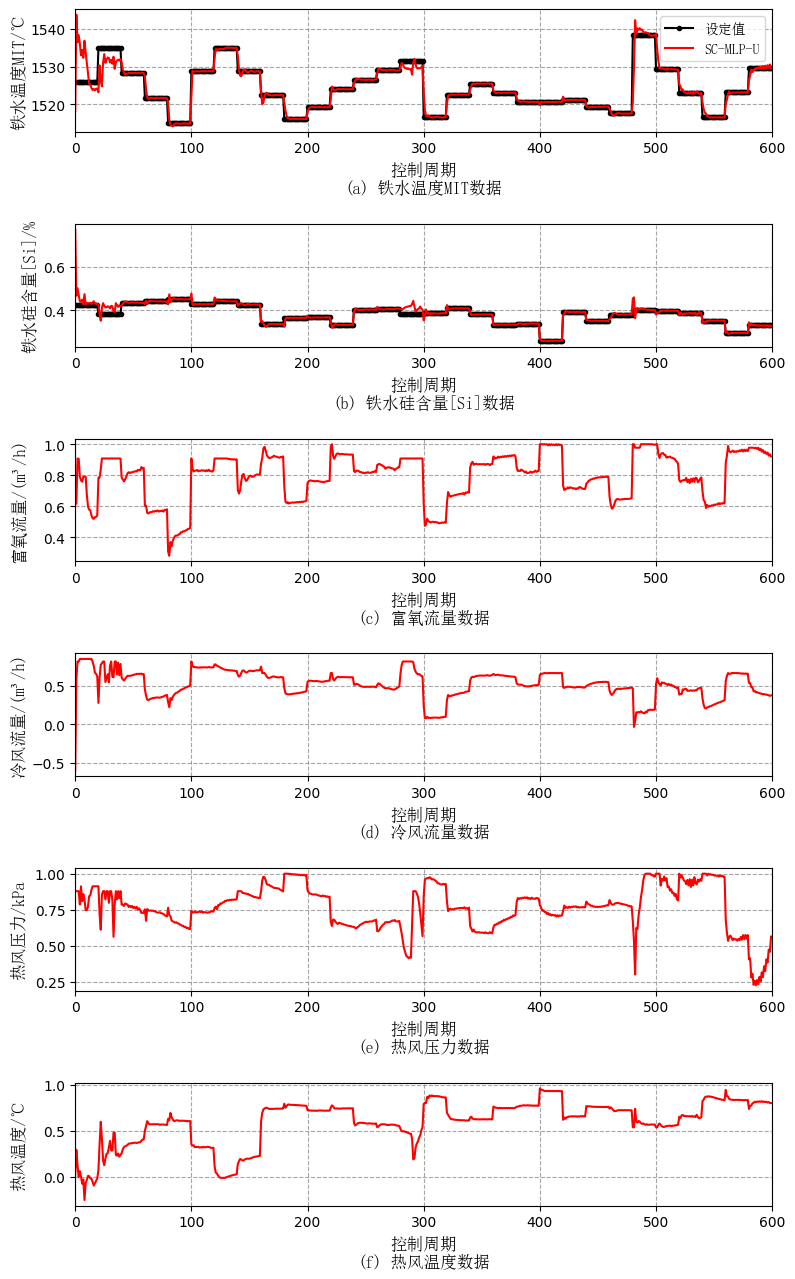

In [93]:
font222 = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=10)  # 替换为你的中文字体文件路径

y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1[startt:endd]).reshape(-1, 1)).flatten()
y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2[startt:endd]).reshape(-1, 1)).flatten()
all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1[startt:endd]).reshape(-1, 1)).flatten()
all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2[startt:endd]).reshape(-1, 1)).flatten()
all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3[startt:endd]).reshape(-1, 1)).flatten()
all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4[startt:endd]).reshape(-1, 1)).flatten()


a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')


rmse_1 = np.mean(np.fabs(set_y1[startt:endd]-y1_pred_inverse_transform))
rmse_2 = np.mean(np.fabs(set_y2[startt:endd]-y2_pred_inverse_transform))
print('平均误差',rmse_1.round(4))
print('平均误差',rmse_2.round(4))









# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(8, 13))

# 第一个维度的曲线
ax = plt.subplot(6, 1, 1)
plt.plot(set_y1[startt:endd], 'k.-', label='设定值')
plt.plot(y1_pred_inverse_transform, 'r', label='SC-MLP-U')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel('铁水温度MIT/℃', fontproperties=font)  # 使用中文标签
plt.legend(prop=font222)
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边

input_term222 =        ['富氧流量/(m\u00b3/h)', '冷风流量/(m\u00b3/h)', '热风压力/kPa', '热风温度/℃']
output_term222 = ['铁水温度MIT/℃', '铁水硅含量[Si]/%']
time_term= '时间戳h'
input_term333 =        ['富氧流量', '冷风流量', '热风压力', '热风温度']
output_term333 = ['铁水温度MIT', '铁水硅含量[Si]']
time_term= '时间戳h'
# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
dtiem = -0.5




ax.text(0.5, dtiem, f'{subplot_labels[0]} {output_term333[0]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签




# 第二个维度的曲线
ax = plt.subplot(6, 1, 2)
plt.plot(set_y2[startt:endd], 'k.-')
plt.plot(y2_pred_inverse_transform, 'r')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel('铁水硅含量[Si]/%', fontproperties=font)  # 使用中文标签
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.text(0.5, dtiem, f'{subplot_labels[1]} {output_term333[1]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签




# 第一个维度的u1曲线
ax = plt.subplot(6, 1, 3)
plt.plot(all_pred_u1[startt:endd], 'r')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel(input_term222[0], fontproperties=font)  # 使用中文标签
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
ax.text(0.5, dtiem, f'{subplot_labels[2]} {input_term333[0]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# 第二个维度的u2曲线
ax = plt.subplot(6, 1, 4)
plt.plot(all_pred_u2[startt:endd], 'r')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel(input_term222[1], fontproperties=font)  # 使用中文标签
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
ax.text(0.5, dtiem, f'{subplot_labels[3]} {input_term333[1]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# 第三个维度的u3曲线
ax = plt.subplot(6, 1, 5)
plt.plot(all_pred_u3[startt:endd], 'r')  # 修改标签为 'u3'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel(input_term222[2], fontproperties=font)  # 使用中文标签
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
ax.text(0.5, dtiem, f'{subplot_labels[4]} {input_term333[2]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# 第四个维度的u4曲线
ax = plt.subplot(6, 1, 6)
plt.plot(all_pred_u4[startt:endd], 'r')  # 修改标签为 'u4'
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlim((0,endd-startt))
plt.ylabel(input_term222[3], fontproperties=font)  # 使用中文标签
plt.grid(linestyle='--', alpha=0.7, color='gray')
ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
ax.text(0.5, dtiem, f'{subplot_labels[5]} {input_term333[3]}数据', 
            transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
    # 添加横坐标标题
ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签



# 调整子图布局
plt.tight_layout()
plt.show()



(0.0, 600.0)

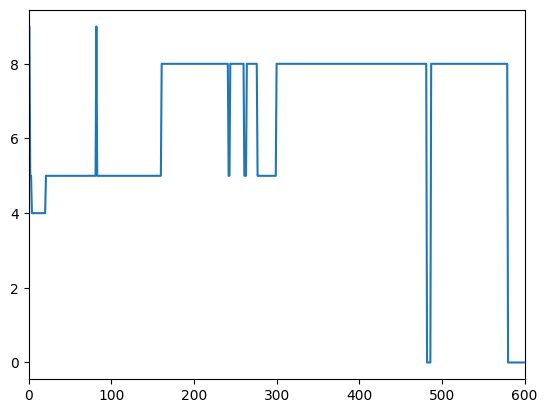

In [95]:
plt.plot(all_state[startt:endd])
plt.xlim([0,len(all_state)])


In [96]:
data_result = {
    input_term[0]: all_pred_u1[startt:endd],
    input_term[1]: all_pred_u2[startt:endd],
    input_term[2]: all_pred_u3[startt:endd],
    input_term[3]: all_pred_u4[startt:endd],
    output_term[0]: all_pred_y1[startt:endd],
    output_term[1]: all_pred_y2[startt:endd],
    'err1':set_y1[startt:endd]-y1_pred_inverse_transform,
    'err2':set_y2[startt:endd]-y2_pred_inverse_transform,
}

# 将字典转换为 DataFrame
df_result = pd.DataFrame(data_result)

# # 查看生成的 DataFrame
# print(df_result)


In [97]:
# import pickle

# # 保存字典到 pickle 文件
# with open('result_data.pkl', 'wb') as file:
#     pickle.dump(data, file)


In [98]:
# import pickle

# # 从 pickle 文件加载字典
# with open('result_data_88000.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# # 打印加载的数据以确认
# print(loaded_data)



# data = loaded_data
# df_result = pd.DataFrame(data)


In [99]:
import numpy as np

# 将 data 中的各列转换为 NumPy 数组以便进行布尔索引
data_array = {key: np.array(value) for key, value in data.items()}

# 计算布尔掩码，满足条件的值为 True
mask = (np.fabs(data_array['err1']) <= 1.5) & (np.fabs(data_array['err2']) <= 0.02)

# 根据掩码筛选每列数据，保留符合条件的行
filtered_data = {key: value[mask] for key, value in data_array.items()}

# 将 NumPy 数组转换回字典
filtered_data_dict = {key: value.tolist() for key, value in filtered_data.items()}

# 输出转换后的字典
for key, value in filtered_data_dict.items():
    print(f"{key}: {value}")
# 将字典转换为 DataFrame
df_result2 = pd.DataFrame(filtered_data_dict)


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
plt.subplot(2,1,1)
plt.plot(data['err1'])
plt.plot(filtered_data_dict['err1'])
plt.subplot(2,1,2)
plt.plot(data['err2'])
plt.plot(filtered_data_dict['err2'])


In [ ]:
# 创建一个大的图形
fig, axs = plt.subplots(len(input_term), len(input_term), figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
expanded_hulls_data = {}
# 循环处理每一对变量
for i in range(len(input_term)):
    for j in range(i + 1, len(input_term)):
        term1 = input_term[i]
        term2 = input_term[j]
        
        x = loaded_data_df_normal[term1]
        y = loaded_data_df_normal[term2]
        
        ax = axs[i, j]
        result = process_cluster_data(ax, x, y, 
                                      term1, term2, df_result2,
                                      eps=3, min_samples=3, buffer_distance=0.10,

                                      )
        # 将结果添加到字典中
        expanded_hulls_data.update(result)

plt.tight_layout()
plt.show()


In [ ]:
plt.subplot(2,1,1)

plt.plot(set_y1[startt:endd]-y1_pred_inverse_transform)
plt.subplot(2,1,2)
plt.plot(set_y2[startt:endd]-y2_pred_inverse_transform)



In [ ]:
# font222 = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=10)  # 替换为你的中文字体文件路径

# y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1[startt:endd]).reshape(-1, 1)).flatten()
# y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4[startt:endd]).reshape(-1, 1)).flatten()


# a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')


# rmse_1 = np.mean(np.fabs(set_y1[startt:endd]-y1_pred_inverse_transform))
# rmse_2 = np.mean(np.fabs(set_y2[startt:endd]-y2_pred_inverse_transform))
# print('平均误差',rmse_1.round(4))
# print('平均误差',rmse_2.round(4))









# # 模型预测控制结果可视化
# # 创建两个子图，分别绘制每个维度
# plt.figure(figsize=(8, 13))

# # 第一个维度的曲线
# ax = plt.subplot(6, 1, 1)
# plt.plot(set_y1[startt:endd], 'k.-', label='设定值')
# plt.plot(y1_pred_inverse_transform, 'r', label='SC-MLP-U')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel('铁水温度MIT/℃', fontproperties=font)  # 使用中文标签
# plt.legend(prop=font222)
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边

# input_term222 =        ['富氧流量/(m\u00b3/h)', '冷风流量/(m\u00b3/h)', '热风压力/kPa', '热风温度/℃']
# output_term222 = ['铁水温度MIT/℃', '铁水硅含量[Si]/%']
# time_term= '时间戳h'
# input_term333 =        ['富氧流量', '冷风流量', '热风压力', '热风温度']
# output_term333 = ['铁水温度MIT', '铁水硅含量[Si]']
# time_term= '时间戳h'
# # 用于子图编号的字母序列
# subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
# dtiem = -0.5




# ax.text(0.5, dtiem, f'{subplot_labels[0]} {output_term333[0]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签




# # 第二个维度的曲线
# ax = plt.subplot(6, 1, 2)
# plt.plot(set_y2[startt:endd], 'k.-')
# plt.plot(y2_pred_inverse_transform, 'r')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel('铁水硅含量[Si]/%', fontproperties=font)  # 使用中文标签
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.text(0.5, dtiem, f'{subplot_labels[1]} {output_term333[1]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签




# # 第一个维度的u1曲线
# ax = plt.subplot(6, 1, 3)
# plt.plot(all_pred_u1_inverse_transform, 'r')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylim((a1[1],a1[0]))
# plt.ylabel(input_term222[0], fontproperties=font)  # 使用中文标签
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
# ax.text(0.5, dtiem, f'{subplot_labels[2]} {input_term333[0]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# # 第二个维度的u2曲线
# ax = plt.subplot(6, 1, 4)
# plt.plot(all_pred_u2_inverse_transform, 'r')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylim((a2[1],a2[0]))
# plt.ylabel(input_term222[1], fontproperties=font)  # 使用中文标签
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
# ax.text(0.5, dtiem, f'{subplot_labels[3]} {input_term333[1]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# # 第三个维度的u3曲线
# ax = plt.subplot(6, 1, 5)
# plt.plot(all_pred_u3_inverse_transform, 'r')  # 修改标签为 'u3'
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylim((a3[1],a3[0]))
# plt.ylabel(input_term222[2], fontproperties=font)  # 使用中文标签
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
# ax.text(0.5, dtiem, f'{subplot_labels[4]} {input_term333[2]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签

# # 第四个维度的u4曲线
# ax = plt.subplot(6, 1, 6)
# plt.plot(all_pred_u4_inverse_transform, 'r')  # 修改标签为 'u4'
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylim((a4[1],a4[0]))
# plt.ylabel(input_term222[3], fontproperties=font)  # 使用中文标签
# plt.grid(linestyle='--', alpha=0.7, color='gray')
# ax.yaxis.set_label_coords(-0.07, 0.5)  # 固定纵坐标标签在最左边
# ax.text(0.5, dtiem, f'{subplot_labels[5]} {input_term333[3]}数据', 
#             transform=ax.transAxes, ha='center', fontproperties=font)  # 添加每个子图的标题在下方
#     # 添加横坐标标题
# ax.set_xlabel('控制周期', fontproperties=font)  # 只给最下面的子图添加横坐标标签



# # 调整子图布局
# plt.tight_layout()
# plt.show()



In [ ]:
# y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1[startt:endd]).reshape(-1, 1)).flatten()
# y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3[startt:endd]).reshape(-1, 1)).flatten()
# all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4[startt:endd]).reshape(-1, 1)).flatten()

# # # 将数据转换为DataFrame
# # data = {
# #     'set_y1': set_y1,
# #     'set_y2': set_y2,
# #     'RES_MLP_U_y1': y1_pred_inverse_transform,
# #     'MLP_U_y2': y2_pred_inverse_transform,
# #     'RES_MLP_U_u1': all_pred_u1_inverse_transform,
# #     'RES_MLP_U_u2': all_pred_u2_inverse_transform,
# #     'RES_MLP_U_u3': all_pred_u3_inverse_transform,
# #     'RES_MLP_U_u4': all_pred_u4_inverse_transform
# # }

# # df = pd.DataFrame(data)

# # # 保存DataFrame到Excel文件
# # df.to_excel('pred_data_RES_MLP_U_'+str(cengshu)+'.xlsx', index=False)




# a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
# print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')


# rmse_1 = np.mean(np.fabs(set_y1[startt:endd]-y1_pred_inverse_transform))
# rmse_2 = np.mean(np.fabs(set_y2[startt:endd]-y2_pred_inverse_transform))
# print('平均误差',rmse_1.round(4))
# print('平均误差',rmse_2.round(4))

# # 模型预测控制结果可视化
# # 创建两个子图，分别绘制每个维度
# plt.figure(figsize=(10, 6))

# # 第一个维度的曲线
# plt.subplot(2, 1, 1)
# plt.plot(set_y1[startt:endd], 'ro-', label='设定值')
# plt.plot(y1_pred_inverse_transform, 'bo-', label='RES_MLP_U 实际值')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
# plt.legend(prop=font)
# plt.grid(linestyle='--', alpha=0.7, color='gray')

# # 第二个维度的曲线
# plt.subplot(2, 1, 2)
# plt.plot(set_y2[startt:endd], 'ro-')
# plt.plot(y2_pred_inverse_transform, 'bo-')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
# plt.legend()
# plt.grid(linestyle='--', alpha=0.7, color='gray')

# # 调整子图布局
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 8))
# # 第一个维度的u1曲线
# plt.subplot(4, 1, 1)
# plt.plot(all_pred_u1_inverse_transform, 'bo-')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
# plt.legend()
# plt.grid(linestyle='--', alpha=0.7, color='gray')

# # 第二个维度的u2曲线
# plt.subplot(4, 1, 2)
# plt.plot(all_pred_u2_inverse_transform, 'bo-')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
# plt.legend()
# plt.grid(linestyle='--', alpha=0.7, color='gray')

# # 第三个维度的u3曲线
# plt.subplot(4, 1, 3)
# plt.plot(all_pred_u3_inverse_transform, 'bo-')  # 修改标签为 'u3'
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
# plt.legend()
# plt.grid(linestyle='--', alpha=0.7, color='gray')

# # 第四个维度的u4曲线
# plt.subplot(4, 1, 4)
# plt.plot(all_pred_u4_inverse_transform, 'bo-')  # 修改标签为 'u4'
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlim((0,endd-startt))
# plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
# plt.legend()
# plt.grid(linestyle='--', alpha=0.7, color='gray')


In [ ]:
os.system(r'C:\Users\haokw\Desktop\11111.mp3')


优化解的分布

In [ ]:
data = {
    input_term[0]: all_pred_u1[startt:endd],
    input_term[1]: all_pred_u2[startt:endd],
    input_term[2]: all_pred_u3[startt:endd],
    input_term[3]: all_pred_u4[startt:endd],
    output_term[0]: all_pred_y1[startt:endd],
    output_term[1]: all_pred_y2[startt:endd]
}

# 将字典转换为 DataFrame
df_result = pd.DataFrame(data)

# 查看生成的 DataFrame
print(df_result)


In [ ]:
# plt.plot(data[output_term[0]])


In [34]:
def ggg():
    i = 0


(6972, 6)
<class 'numpy.ndarray'>
Output data shape: (6972, 6)
Input data shape: (6972, 4)
[ 0.09247779 -0.15088405  0.17762792  0.55379182]
[0.97724495 0.62384595 0.96152718 1.        ]
[-0.07558958  0.01253782  0.20657989 -0.2372904 ]
[0.89923923 0.83600497 0.87501001 0.69791013]
[ 0.26536768 -0.15286955  0.17376241  0.40061033]
[0.99713025 0.65587906 0.92778848 0.98857266]
[-0.82989307 -0.04015109 -0.11761979 -1.        ]
[ 0.09695982  1.          0.73797509 -0.17772136]
[-0.20707883  0.10282484  0.10428009 -0.38571056]
[0.79087545 0.84410564 0.91243101 0.32497236]
[ 0.13320595  0.03818414  0.3169751  -0.00832391]
[0.9079424  0.81082604 0.87854949 0.76672909]
[-0.75662568 -0.1277872   0.01978125 -0.73702604]
[0.39311128 0.99517434 0.8467295  0.38912251]
[ 0.34737355 -0.32732619 -0.08983676  0.52685543]
[0.96612321 0.63750214 0.70474199 0.99583266]
[ 0.36769047 -0.03580518  0.53332456  0.53803426]
[1.         0.66147044 1.         0.95861219]
[-0.5896518  -0.60068708 -0.08483353 -0.1

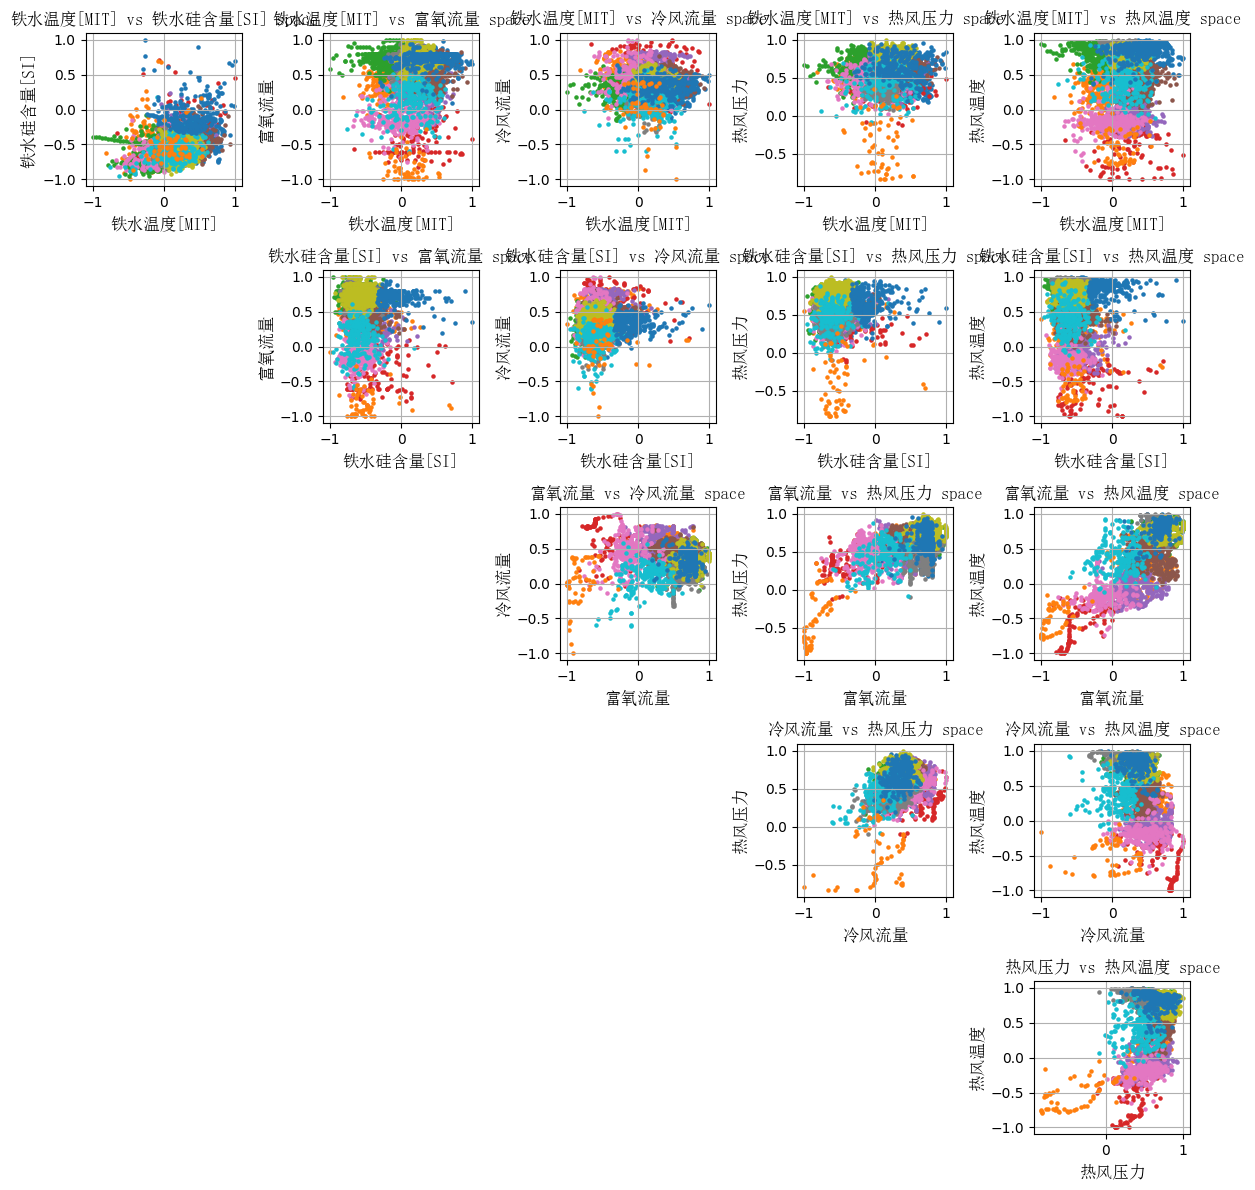

In [84]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.decomposition import KernelPCA
# 提取 output_term 和 input_term 的数据
def extract_data(data, terms):
    return np.column_stack([data[term] for term in terms])

# output_data = extract_data(data2_all, output_term+last_output_term)
# input_data = extract_data(data2_all, input_term)
output_data = extract_data(data2_all, output_term+last_input_term)
input_data = extract_data(data2_all, input_term)
print(output_data.shape)
print(type(output_data))
print(f'Output data shape: {output_data.shape}')
print(f'Input data shape: {input_data.shape}')



# 使用 KernelPCA 将数据映射到高维空间
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.2)
# transformed_data = kpca.fit_transform(output_data)


# 使用 K-Means 对 output_term 进行聚类5
n_clusters = 12
# random_state = 42  # 固定随机数种子
kmeans = KMeans(n_clusters=n_clusters)
# 使用 K-Means 对 output_term 进行聚类5
# n_clusters = len(set(labels))
# # random_state = 42  # 固定随机数种子
# kmeans = MeanShift()
labels = kmeans.fit_predict(output_data)

# n_clusters = len(set(labels))

# 计算每个子模态的 input_term 空间分布范围
def compute_limits(input_data, labels, n_clusters):
    limits = {}
    for i in range(n_clusters):
        cluster_data = input_data[labels == i]
        min_limits = cluster_data.min(axis=0)
        max_limits = cluster_data.max(axis=0)
        print(min_limits)
        print(max_limits)
        # limits[i] = {input_term[j]: (min_limits[j], max_limits[j]) for j in range(len(input_term))}
        limits[i] = {input_term[j]: (min_limits[j], max_limits[j]) for j in range(len(input_term))}
    return limits





input_term_limits = compute_limits(input_data, labels, n_clusters)

# 输出每个子模态的 input_term 限制范围
def print_limits(limits):
    for mode, terms in limits.items():
        print(f"Mode {mode}:")
        for term, (min_val, max_val) in terms.items():
            print(f"  {term}: Min={min_val}, Max={max_val}")

print_limits(input_term_limits)


def plot_clusters_pairwise(output_data, labels, terms):
    plt.figure(figsize=(12, 12))
    n_clusters = len(set(labels))  # 假设labels是从0开始编号的簇标签
    num_terms = len(terms)

    # 遍历所有的维度组合（两两配对）
    for i in range(num_terms):
        for j in range(i+1, num_terms):
            plt.subplot(num_terms-1, num_terms-1, i*(num_terms-1) + j)
            for k in range(n_clusters):
                cluster_data = output_data[labels == k]
                plt.scatter(cluster_data[:, i], cluster_data[:, j], s=5, label=f'Mode {k}')
            plt.title(f'{terms[i]} vs {terms[j]} space', fontproperties=font)
            plt.xlabel(terms[i], fontproperties=font)
            plt.ylabel(terms[j], fontproperties=font)
            # plt.legend()
            plt.grid(True)

    plt.tight_layout()
    plt.show()

# 假设output_term和last_output_term组合在一起
# terms = output_term + last_output_term
terms = output_term+last_input_term
plot_clusters_pairwise(output_data, labels, terms)


In [73]:
# 查看 labels 的种类及数量
unique_labels = np.unique(labels)
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")
# 统计每个标签出现的次数
label_counts = np.bincount(labels)
for label, count in enumerate(label_counts):
    print(f"Label {label}: {count} points")


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Number of unique labels: 12
Label 0: 1110 points
Label 1: 498 points
Label 2: 96 points
Label 3: 1071 points
Label 4: 669 points
Label 5: 99 points
Label 6: 140 points
Label 7: 1072 points
Label 8: 378 points
Label 9: 226 points
Label 10: 1053 points
Label 11: 561 points


In [74]:
# import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# from sklearn.decomposition import KernelPCA
# # 提取 output_term 和 input_term 的数据
# def extract_data(data, terms):
#     return np.column_stack([data[term] for term in terms])

# output_data = extract_data(data2_all, output_term+last_output_term)
# input_data = extract_data(data2_all, input_term)
# print(output_data.shape)
# print(type(output_data))
# print(f'Output data shape: {output_data.shape}')
# print(f'Input data shape: {input_data.shape}')



# # 使用 KernelPCA 将数据映射到高维空间
# # kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1)
# # transformed_data = kpca.fit_transform(output_data)



# # 使用 K-Means 对 output_term 进行聚类5
# n_clusters = 5
# # random_state = 42  # 固定随机数种子
# kmeans = KMeans(n_clusters=n_clusters)
# labels = kmeans.fit_predict(output_data)

# # 计算每个子模态的 input_term 空间分布范围
# def compute_limits(input_data, labels, n_clusters):
#     limits = {}
#     for i in range(n_clusters):
#         cluster_data = input_data[labels == i]
#         min_limits = cluster_data.min(axis=0)
#         max_limits = cluster_data.max(axis=0)
#         print(min_limits)
#         print(max_limits)
#         limits[i] = {input_term[j]: (min_limits[j], max_limits[j]) for j in range(len(input_term))}
#     return limits





# input_term_limits = compute_limits(input_data, labels, n_clusters)

# # 输出每个子模态的 input_term 限制范围
# def print_limits(limits):
#     for mode, terms in limits.items():
#         print(f"Mode {mode}:")
#         for term, (min_val, max_val) in terms.items():
#             print(f"  {term}: Min={min_val}, Max={max_val}")

# print_limits(input_term_limits)


# def plot_clusters_pairwise(output_data, labels, terms):
#     plt.figure(figsize=(12, 12))
#     n_clusters = len(set(labels))  # 假设labels是从0开始编号的簇标签
#     num_terms = len(terms)

#     # 遍历所有的维度组合（两两配对）
#     for i in range(num_terms):
#         for j in range(i+1, num_terms):
#             plt.subplot(num_terms-1, num_terms-1, i*(num_terms-1) + j)
#             for k in range(n_clusters):
#                 cluster_data = output_data[labels == k]
#                 plt.scatter(cluster_data[:, i], cluster_data[:, j], s=5, label=f'Mode {k}')
#             plt.title(f'{terms[i]} vs {terms[j]} space', fontproperties=font)
#             plt.xlabel(terms[i], fontproperties=font)
#             plt.ylabel(terms[j], fontproperties=font)
#             plt.legend()
#             plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# # 假设output_term和last_output_term组合在一起
# terms = output_term + last_output_term
# plot_clusters_pairwise(output_data, labels, terms)


C:\Users\haokw\AppData\Local\Temp\ipykernel_4716\1143974311.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_clusters)  # 选用 'tab20' 调色板，也可选其他如 'viridis', 'plasma'


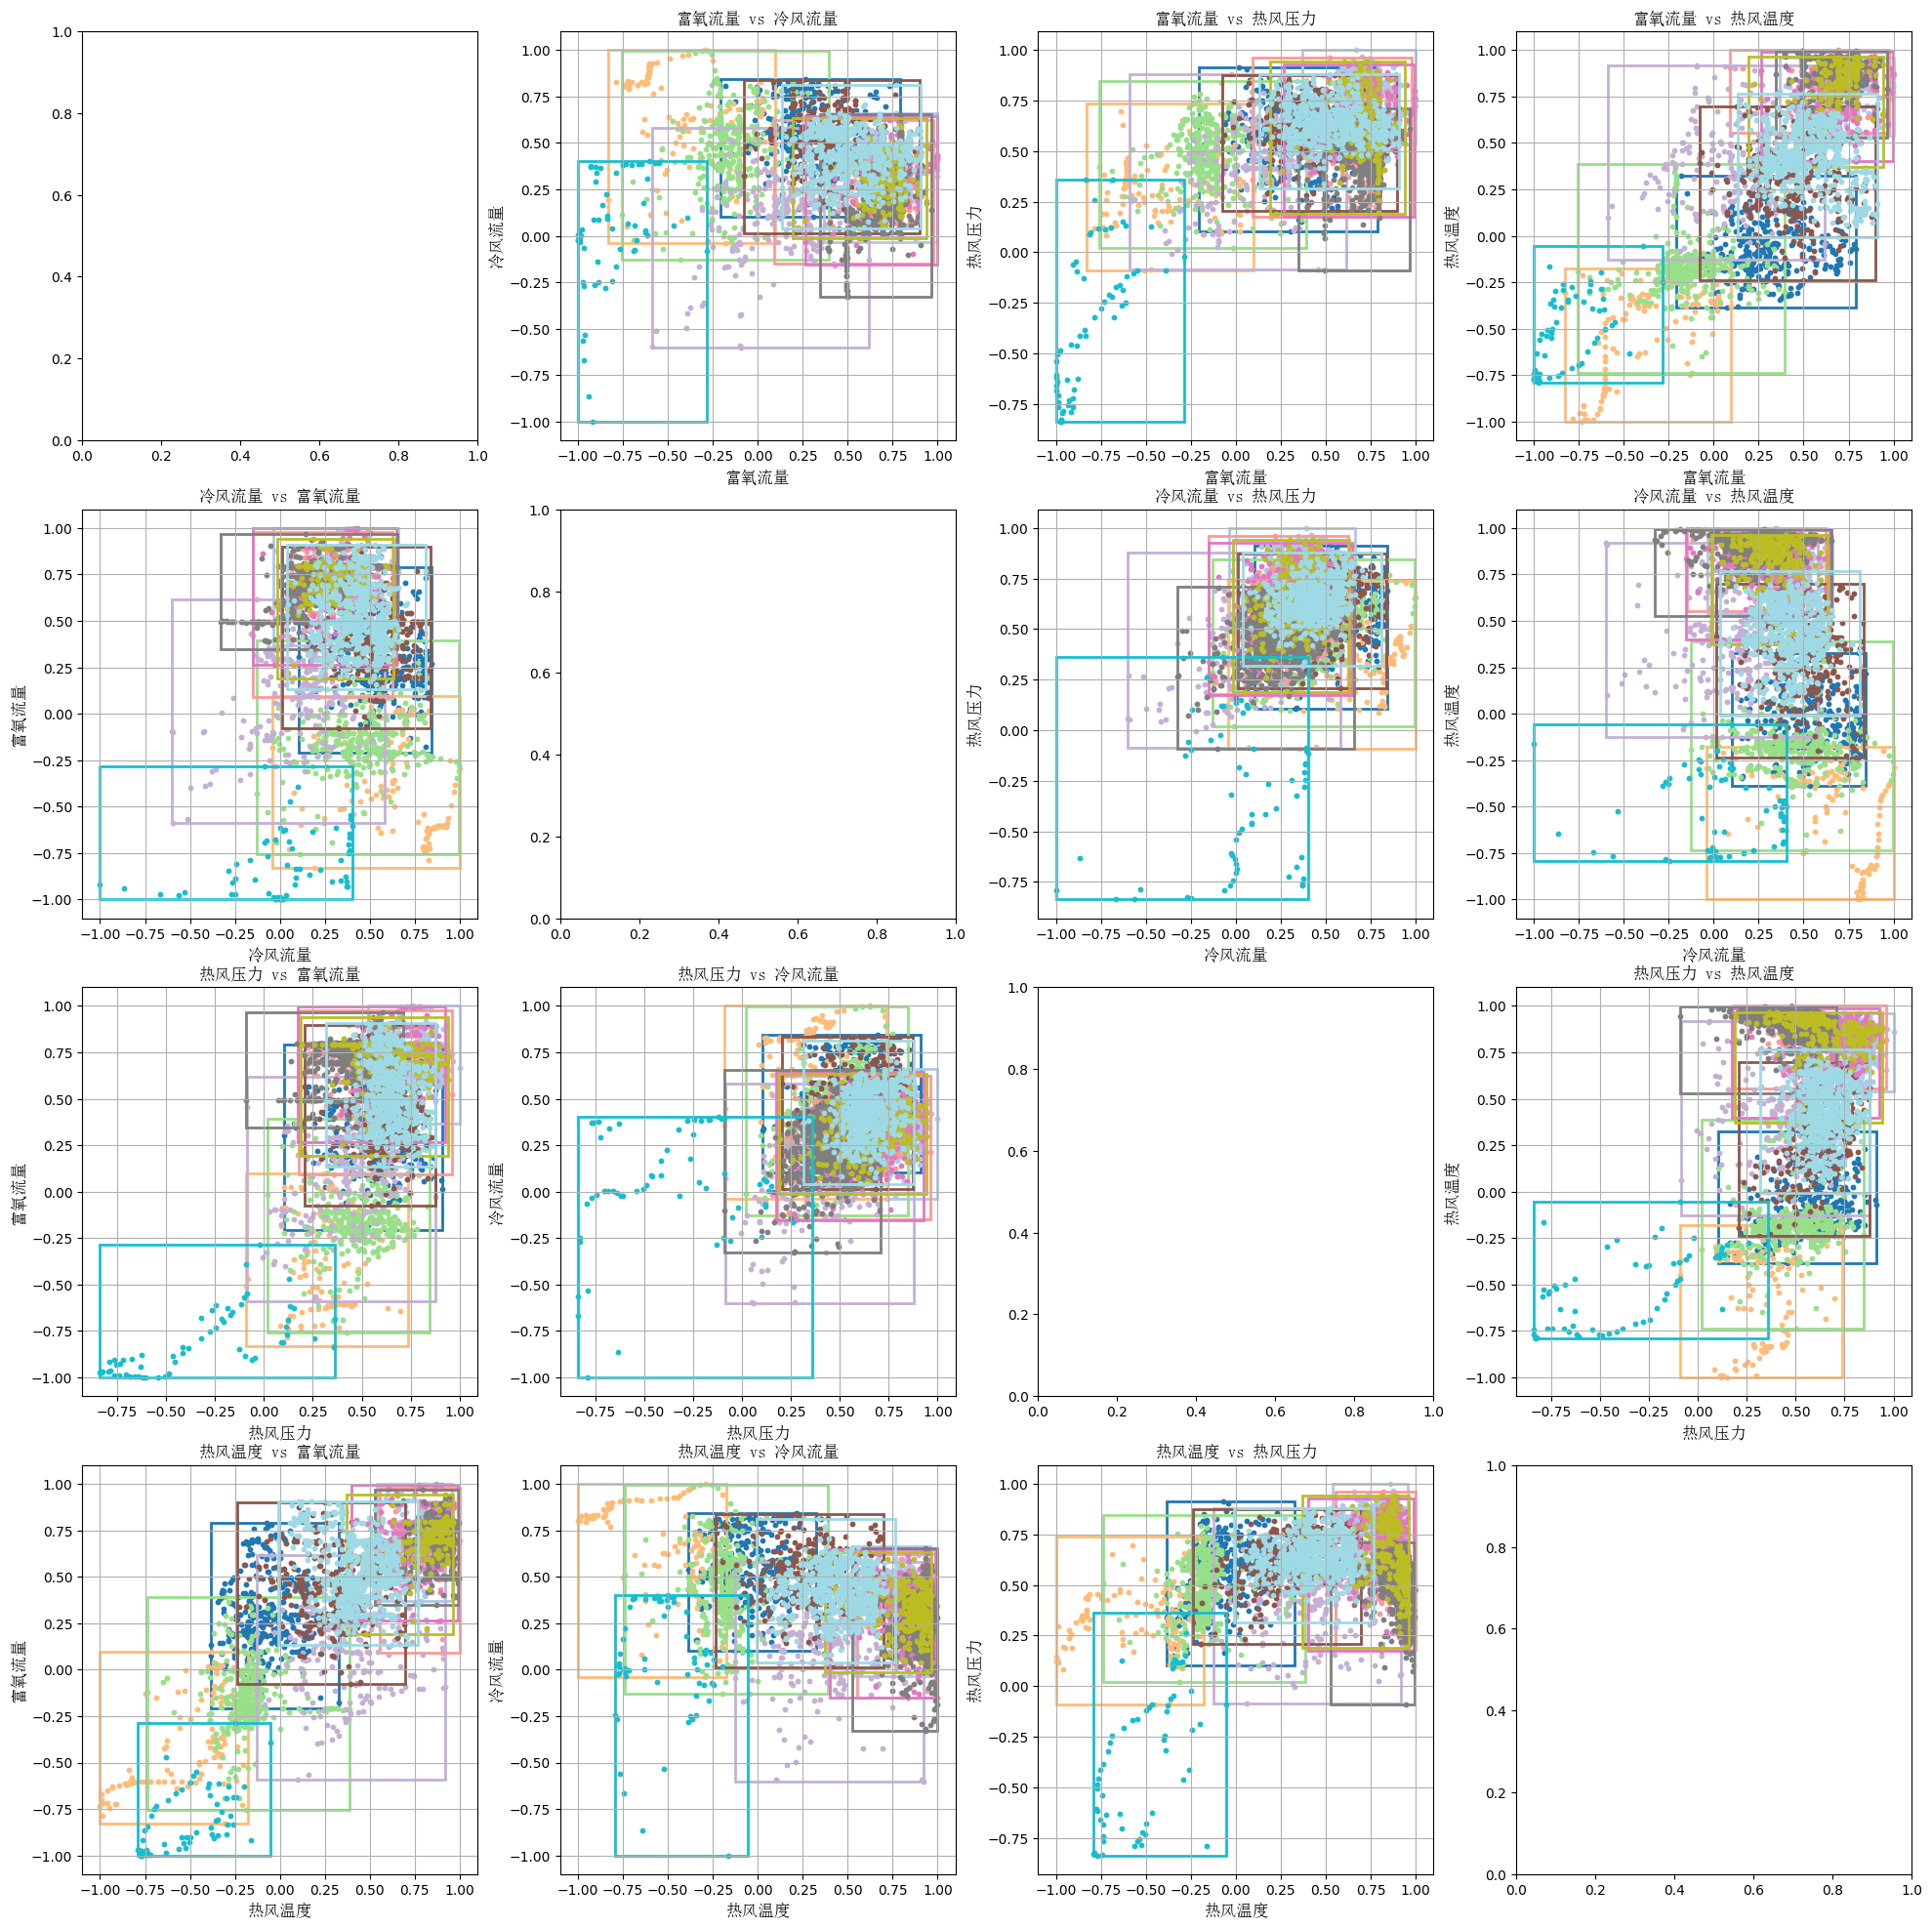

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化不同标签下 input_term 数据的二维分布，并绘制边界框
def plot_input_term_distribution(ax, input_data, labels, input_term, x_index=0, y_index=1, limits=None, n_clusters=12):
    # 使用颜色映射为每个簇生成不同的颜色
    colors = plt.cm.get_cmap('tab20', n_clusters)  # 选用 'tab20' 调色板，也可选其他如 'viridis', 'plasma'
    
    for i in range(n_clusters):
        cluster_data = input_data[labels == i]
        
        # 从 colormap 中获取当前簇的颜色
        color = colors(i)
        
        # 在传入的 ax 上绘制散点
        ax.scatter(cluster_data[:, x_index], cluster_data[:, y_index], s=10, label=f'Mode {i}', color=color)
        
        # 如果提供了边界条件，绘制边界框
        if limits is not None and i in limits:
            x_min, x_max = limits[i][input_term[x_index]]
            y_min, y_max = limits[i][input_term[y_index]]
            
            # 绘制矩形，颜色与散点颜色一致
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor=color, facecolor='none', label=f'Boundary {i}')
            ax.add_patch(rect)
    
    ax.set_title(f'{input_term[x_index]} vs {input_term[y_index]}',fontproperties = font)
    ax.set_xlabel(input_term[x_index],fontproperties = font)
    ax.set_ylabel(input_term[y_index],fontproperties = font)
    ax.grid(True)

# 获取 input_term 的数量
# num_terms = len(input_term)
num_terms = len(input_term)

# 创建 num_terms x num_terms 的子图
fig, axes = plt.subplots(num_terms, num_terms, figsize=(num_terms*5, num_terms*5))
fig.tight_layout(pad=3.0)

# 遍历所有的 (i, j) 组合，分别绘制在各自的子图上
for i in range(num_terms):
    for j in range(num_terms):
        ax = axes[i, j]  # 获取对应的子图
        if i == j :
            continue
        # plot_input_term_distribution(ax, input_data, labels, input_term, 
        #                              x_index=i, y_index=j, 
        #                              limits=input_term_limits, 
        #                              n_clusters=n_clusters)
        plot_input_term_distribution(ax, input_data, labels, input_term, 
                                     x_index=i, y_index=j, 
                                     limits=input_term_limits, 
                                     n_clusters=n_clusters)

# 显示所有子图
plt.show()


In [ ]:
plt.subplots(4, 1, figsize=(10, 10))

for i in range(len(input_term)):
    plt.subplot(4, 1, i + 1)
    
    # 绘制每个簇的数据
    for j in range(n_clusters):
        cluster_data = input_data[labels == j]
        plt.plot(cluster_data[:, i], label=f'Cluster {j}')  # 使用标签显示簇编号
    
    # 添加坐标轴标签和标题
    plt.xlabel('Index')  # x 轴是索引或时间步长
    plt.ylabel(input_term[i],fontproperties = font)  # y 轴是当前的 input_term 项
    plt.title(f'{input_term[i]} Distribution Across Clusters',fontproperties = font) # 标题根据 input_term 的名称设定
    plt.legend()  # 添加图例
    plt.grid(True)  # 显示网格

plt.tight_layout()  # 自动调整子图布局以避免重叠
plt.show()


In [ ]:
plt.subplots(4, 1, figsize=(10, 10))
for i in range(0,len(input_term)):
    plt.subplot(4,1,i+1)
    for j in range(0,n_clusters):
        cluster_data = input_data[labels == j]
        # print(cluster_data[:,0].shape)
        plt.plot(cluster_data[:,i])


In [ ]:
new_data = np.column_stack([set_y1_trans[1:],set_y2_trans[1:],set_y1_trans[:-1],set_y2_trans[:-1]])
print(new_data.shape)
print(type(new_data))
new_data
label = kmeans.predict(new_data)
print(label)


In [ ]:
new_data = np.column_stack([set_y1_trans,set_y2_trans])
print(new_data.shape)
print(type(new_data))
new_data
label = kmeans.predict(new_data)
plt.plot(label)


In [482]:
# print(type(output_data))


In [483]:

# labels = kmeans.predict(y_gaolu_train)


In [484]:
# 绘制散点图矩阵
# beilv = 4
# plot_scatter_matrix(loaded_data_df_normal, df_result, font=font, figsize=(10*beilv, 8*beilv))

# plot_scatter_matrix(X_df_normal, df_result, font=font, figsize=(10*beilv, 8*beilv))


vu与哦i

In [ ]:
with open(r'C:\Users\haokw\Documents\GitHub\gaolu\up2\original_data_dict.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Data loaded:", loaded_data)

# 进行归一化
loaded_data_dict = {}
for column, scaler in scalers.items():
    if column in input_term:
        loaded_data_dict[column] = scaler.transform(loaded_data[column].reshape(-1, 1)).flatten()

loaded_data_df_normal = pd.DataFrame(loaded_data_dict, columns=input_term)

loaded_data_df_normal = loaded_data_df_normal.loc[~(loaded_data_df_normal <= -0.9).any(axis=1)].reset_index(drop=True)


print(loaded_data_df_normal.shape)

loaded_data_df_normal = loaded_data_df_normal.iloc[::80,:].reset_index(drop=True).dropna()#返回第一行
check_if_NaN(loaded_data_df_normal)
# 绘制散点图矩阵
# plot_scatter_matrix(X_df_normal, loaded_data_df_normal, font=font, figsize=(10, 8))



In [57]:
# # 绘制散点图矩阵
# beilv = 1
# # plot_scatter_matrix(X_df_normal, df_result, font=font, figsize=(10*beilv, 8*beilv))

# plot_scatter_matrix(loaded_data_df_normal, df_result, font=font, figsize=(10*beilv, 8*beilv))
# # plot_scatter_matrix(filtered_df, df_result, font=font, figsize=(10*beilv, 8*beilv))




In [487]:
# vu与哦i


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import MultiPoint, Polygon
import matplotlib.font_manager as fm

def process_cluster_data(ax, x, y, 
                         term1, term2, df_result,
                         eps=3, min_samples=3, buffer_distance=0.10):
    """
    处理数据，执行聚类，并在指定的轴上绘制聚类结果和扩展边界。

    :param ax: matplotlib 的 Axes 对象
    :param x: 变量1的值
    :param y: 变量2的值
    :param eps: DBSCAN 的 eps 参数
    :param min_samples: DBSCAN 的 min_samples 参数
    :param buffer_distance: 扩展量，用于边界扩展
    :param term1: 变量1的名称
    :param term2: 变量2的名称
    """
    # 将数据合并为二维数组
    data = np.column_stack((x, y))

    # 1. 计算每个数据点的密度
    kde = gaussian_kde(data.T)
    densities = kde(data.T)

    # 2. 根据密度排序并选择前100%的数据点
    sorted_indices = np.argsort(densities)[::-1]  # 从高到低排序
    sorted_data = data[sorted_indices]
    sorted_densities = densities[sorted_indices]

    # 选择前100%的数据点
    threshold_index = int(len(sorted_densities) * 1.00)
    top_90_data = sorted_data[:threshold_index]

    # 3. 对前90%的数据点进行聚类
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(top_90_data)
    unique_labels = set(clusters)

    # 4. 绘制聚类结果并包含原始数据
    # 绘制原始数据
    # ax.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.5, label='Original Data')

    for label in unique_labels:
        if label == -1:
            continue  # 忽略噪声点
        cluster_points = top_90_data[clusters == label]
        # ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Original Data")

    # 5. 绘制每个聚类的边界，并在边界上进行外部扩展
    hulls = []
    # 绘制每个聚类的边界，并在边界上进行外部扩展
    for label in unique_labels:
        if label == -1:
            continue  # 忽略噪声点
        cluster_points = top_90_data[clusters == label]
        
        # 计算聚类的凸包边界
        if len(cluster_points) > 2:
            convex_hull = MultiPoint(cluster_points).convex_hull
        else:
            convex_hull = Polygon(cluster_points)
            
        # 扩展边界（使用 buffer 方法进行外部扩展）
        expanded_hull = convex_hull.buffer(buffer_distance)
        hulls.append(expanded_hull)
        
        # 绘制扩展后的边界
        x_hull, y_hull = expanded_hull.exterior.xy
        ax.fill(x_hull, y_hull, alpha=0.3)
        
        # 绘制聚类点
        # ax.scatter(X_df_normal[term1], X_df_normal[term2], label=f"Original Data")
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"cluster_points")
        ax.scatter(df_result[term1], df_result[term2], label=f"Process Data")
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        

    ax.set_xlabel(term1, fontproperties=font)
    ax.set_ylabel(term2, fontproperties=font)
    ax.set_title(f"{term1} vs {term2}", fontproperties=font)
    
    ax.legend(prop=font)
    return {
        (term1, term2): hulls
    }
# {
#     ('富氧流量', '设定喷煤量'): [<POLYGON ...>],
#     ('富氧流量', '热风压力'): [<POLYGON ...>],
#     # 更多数据
# }


In [ ]:
# 创建一个大的图形
fig, axs = plt.subplots(len(input_term), len(input_term), figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
expanded_hulls_data = {}
# 循环处理每一对变量
for i in range(len(input_term)):
    for j in range(i + 1, len(input_term)):
        term1 = input_term[i]
        term2 = input_term[j]
        
        x = loaded_data_df_normal[term1]
        y = loaded_data_df_normal[term2]
        
        ax = axs[i, j]
        result = process_cluster_data(ax, x, y, 
                                      term1, term2, df_result,
                                      eps=3, min_samples=3, 
                                      buffer_distance=0.10)
        # 将结果添加到字典中
        expanded_hulls_data.update(result)

plt.tight_layout()
plt.show()


In [490]:
# plot_scatter_matrix_22222(df_result, df_result, figsize=(10, 8), font=font)


In [ ]:
fdh而也容易


In [ ]:
expanded_hulls_data
import pickle

# 保存 expanded_hulls_data 到文件
with open('expanded_hulls_data.pkl', 'wb') as f:
    pickle.dump(expanded_hulls_data, f)


In [ ]:
print(expanded_hulls_data)


In [ ]:
for key, value in expanded_hulls_data.items():
    print(f"Key: {key}, Value: {value}")



In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import numpy as np

# 选择要绘制的多边形
key = ('冷风流量', '热风温度')

# 确保 expanded_hulls_data 中的值是 Polygon 对象的列表
polygons = expanded_hulls_data[key]

# 创建正方形边界（范围 [-1, 1]）
boundary_box = box(-1, -1, 1, 1)


# 选择要绘制的多边形
key = ('冷风流量', '热风温度')

# 确保 expanded_hulls_data 中的值是 Polygon 对象的列表
polygons = expanded_hulls_data[key]

# 创建正方形边界（范围 [-1, 1]）
boundary_box = box(-1, -1, 1, 1)

# 创建裁剪后的多边形
clipped_polygons = polygon.intersection(boundary_box) for polygon in polygons if not polygon.intersection(boundary_box).is_empty







# 创建图形和坐标轴
fig, ax = plt.subplots()

for polygon in polygons:
    if isinstance(polygon, Polygon):
        # 计算多边形与正方形的交集
        clipped_polygon = polygon.intersection(boundary_box)
        
        if not clipped_polygon.is_empty:
            x_hull, y_hull = clipped_polygon.exterior.xy
            ax.fill(x_hull, y_hull, alpha=0.3, edgecolor='black')

# 设置坐标轴范围
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 2])

# 设置坐标轴的比例为相等，以防止多边形被扭曲
ax.set_aspect('equal')

# 设置坐标轴标签和标题
plt.xlabel('冷风流量')
plt.ylabel('热风温度')
plt.title('多边形边界')

# 显示图形
plt.show()


In [ ]:
而我国v热


In [ ]:
import numpy as np
import pandas as pd

# 定义列名
columns = input_term

# 生成随机数据
num_samples = 100*10000
data = np.random.uniform(-1, 1, size=(num_samples, len(columns)))

# 创建 DataFrame
random_df = pd.DataFrame(data, columns=columns)

# 打印前几行以验证
print(random_df.head())




In [ ]:
import numpy as np
import pandas as pd
from shapely.geometry import Point

# 假设 expanded_hulls_data 是一个包含扩展边界数据的字典
# 格式: {'term1_term2': [expanded_hull, ...]}
# 示例格式为 {('term1', 'term2'): [expanded_hull, ...]}

def filter_points_within_hulls(df, input_terms, expanded_hulls_data):
    """
    根据扩展边界筛选 DataFrame 中的点。

    :param df: 包含随机样本的 DataFrame
    :param input_terms: 列名列表
    :param expanded_hulls_data: 扩展边界数据字典
    :return: 筛选后的 DataFrame
    """
    # 创建一个布尔掩码来标记需要保留的行
    keep_mask = np.ones(len(df), dtype=bool)
    
    # 循环处理每一对变量
    for i in range(len(input_terms)):
        i
        for j in range(i + 1, len(input_terms)):
            term1 = input_terms[i]
            term2 = input_terms[j]
            
            # 取出数据
            x = df[term1]
            y = df[term2]
            
            # 获取对应的扩展边界
            hulls = expanded_hulls_data.get((term1, term2), [])
            
            if not hulls:
                continue
            
            # 计算每个点是否在扩展边界内
            def point_in_any_hull(xi, yi):
                point = Point(xi, yi)
                return any(point.within(hull) for hull in hulls)
            
            # 应用函数并更新掩码
            mask = np.array([point_in_any_hull(xi, yi) for xi, yi in zip(x, y)])
            keep_mask &= mask
    
    # 根据掩码筛选 DataFrame
    filtered_df = df[keep_mask]
    
    return filtered_df

# 使用示例
filtered_df = filter_points_within_hulls(random_df, input_term, expanded_hulls_data)

# 打印筛选后的数据
print(filtered_df.head())



In [ ]:
filtered_df.shape


In [ ]:
# 保存 expanded_hulls_data 到文件
with open('filtered_df.pkl', 'wb') as f:
    pickle.dump(filtered_df, f)


In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# 函数来绘制边界条件和数据
def plot_hulls_and_data(ax, data, term1, term2, expanded_hulls):
    """
    绘制扩展边界和数据点
    
    :param ax: 绘图的轴对象
    :param data: 数据点
    :param term1: 变量1的名称
    :param term2: 变量2的名称
    :param expanded_hulls: 扩展边界的字典
    """
    # 绘制数据点
    ax.scatter(data[term1], data[term2], c='blue', label='Data Points', alpha=0.5)
    
    # 绘制扩展边界
    hulls = expanded_hulls.get((term1, term2), [])
    for hull in hulls:
        if isinstance(hull, Polygon):
            x_hull, y_hull = hull.exterior.xy
            ax.fill(x_hull, y_hull, alpha=0.3)

    ax.set_xlabel(term1, fontproperties=font)
    ax.set_ylabel(term2, fontproperties=font)
    ax.set_title(f'{term1} vs {term2}', fontproperties=font)
    ax.legend()

# 创建一个大的图像和子图
num_vars = len(input_term)
fig, axs = plt.subplots(num_vars, num_vars, figsize=(10, 10))

# 遍历每一对变量
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            term1 = input_term[i]
            term2 = input_term[j]

            ax = axs[i, j]
            
            # 过滤数据点在扩展边界内
            filtered_df = filtered_df[(filtered_df[term1] >= -1) & (filtered_df[term1] <= 1) &
                                        (filtered_df[term2] >= -1) & (filtered_df[term2] <= 1)]

            # 绘制边界条件和数据
            plot_hulls_and_data(ax, filtered_df, term1, term2, expanded_hulls_data)

        else:
            axs[i, j].axis('off')  # 关闭对角线上的子图

plt.tight_layout()
plt.show()


In [ ]:
# GAN超参数  训练数据

# 将历史数据转换为 PyTorch 张量
data_item = random_df
# data_item = data_test

data = torch.tensor(data_item.values, dtype=torch.float32)
df_GAN = data_item
test_sample_num = data.shape[0]



z_dim = 4  # 随机噪声维度
data_dim = data.shape[1]  # 数据维度，4
learning_rate = 0.0002
num_epochs = 200
n_critic = 5  # 每次更新生成器前，更新 Critic 的次数

print_piture_d = 10

# 设置数据加载器
batch_size = 512
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)




In [ ]:
# W-GAN模型定义和训练
# WGAN的生成器
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# WGAN的Critic
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# 权重裁剪
def weight_clipping(critic, clip_value=0.01):
    for param in critic.parameters():
        param.data.clamp_(-clip_value, clip_value)

# WGAN训练
def train_wgan(generator, critic, data_loader, num_epochs, z_dim, clip_value, n_critic, optimizer_G, optimizer_C, output_dir):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for epoch in range(num_epochs):
        for real_data in data_loader:
            batch_size = real_data.size(0)

            # 更新 Critic
            for _ in range(n_critic):
                z = torch.randn(batch_size, z_dim)
                fake_data = generator(z)

                # 计算 Critic 的损失（Wasserstein 距离）
                real_output = critic(real_data)
                fake_output = critic(fake_data.detach())
                c_loss = -torch.mean(real_output) + torch.mean(fake_output)

                optimizer_C.zero_grad()
                c_loss.backward()
                optimizer_C.step()

                # 对 Critic 权重进行裁剪
                weight_clipping(critic, clip_value)

            # 更新生成器
            z = torch.randn(batch_size, z_dim)
            fake_data = generator(z)
            fake_output = critic(fake_data)
            g_loss = -torch.mean(fake_output)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        print(f"WGAN_training Epoch [{epoch}/{num_epochs}], c_loss: {c_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

        if epoch % print_piture_d == print_piture_d-1:
            # 生成一些数据
            z = torch.randn(test_sample_num, z_dim)
            generated_data = generator(z).detach().numpy()

            # 将生成的数据转换为 DataFrame
            generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

            # 获取当前时间
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            # 构建保存路径和文件名
            filename = f"{current_time}_WGAN_Epoch_{epoch+1}_c_loss_{c_loss.item():.4f}_g_loss_{g_loss.item():.4f}.png"
            save_path = os.path.join(output_dir, filename)

            # 可视化生成的数据分布（你可以实现自己的可视化函数）
            plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font, save_path=save_path)


In [ ]:
# 初始化WGAN  训练
wgan_generator = Generator(input_dim=z_dim, output_dim=data_dim)
wgan_critic = Critic(input_dim=data_dim)
# 初始化优化器
optimizer_G = optim.Adam(wgan_generator.parameters(), lr=learning_rate, betas=(0.2, 0.999))
optimizer_C = optim.Adam(wgan_critic.parameters(), lr=learning_rate, betas=(0.2, 0.999))

# 训练WGAN
train_wgan(wgan_generator, wgan_critic, data_loader, 
                num_epochs=num_epochs, z_dim=z_dim, clip_value=0.01, 
                n_critic = 5, 
                optimizer_G=optimizer_G, optimizer_C=optimizer_C, 
                output_dir = r"data\train_output_picture\WGAN_all_data")



# 保存模型参数
def save_model(generator, discriminator, output_dir, epoch):
        # 创建保存目录（如果不存在）
        os.makedirs(output_dir, exist_ok=True)

        # 定义文件名
        generator_filename = os.path.join(output_dir, f"generator.pth")
        discriminator_filename = os.path.join(output_dir, f"discriminator.pth")

        # 保存生成器的模型参数
        torch.save(generator.state_dict(), generator_filename)
        print(f"Generator model saved to {generator_filename}")

        # 保存判别器的模型参数
        torch.save(discriminator.state_dict(), discriminator_filename)
        print(f"Discriminator model saved to {discriminator_filename}")

save_model(wgan_generator, wgan_critic, 
        output_dir=r"data\model_params\wgan_model_all_data", 
        epoch=num_epochs)


In [ ]:
# 生成样本测试
z = torch.randn(test_sample_num, z_dim)
print(z.shape)

generated_data = wgan_generator(z).detach().numpy()
print(generated_data.shape)

# 将生成的数据转换为 DataFrame
generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

# 可视化生成的数据分布（你可以实现自己的可视化函数）
plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font)
plot_scatter_matrix(generated_df, df_result, figsize=(10, 8), font=font)


In [ ]:
# LS-GAN模型定义和训练
class LSGANGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            # nn.ReLU(True),
            nn.Linear(128, 256),
            # nn.ReLU(True),
            nn.Linear(256, output_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# LSGAN的判别器
class LSGANDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(LSGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# # LSGAN的损失函数
# def generator_loss(fake_output):
#     return torch.mean((fake_output - 1) ** 2)

# def discriminator_loss(real_output, fake_output):
#     real_loss = torch.mean((real_output - 1) ** 2)
#     fake_loss = torch.mean(fake_output ** 2)
#     return real_loss + fake_loss


# 定义LSGAN损失函数
def generator_loss(fake_output, generated_data, real_data):
    # LS-GAN 原始损失
    lsgan_loss = torch.mean((fake_output - 1) ** 2)
    # 生成数据与真实数据的MSE匹配损失
    mse_loss = torch.mean((generated_data - real_data) ** 2)
    return lsgan_loss + mse_loss

def discriminator_loss(real_output, fake_output):
    real_loss = torch.mean((real_output - 1) ** 2)
    fake_loss = torch.mean(fake_output ** 2)
    return real_loss + fake_loss



# LSGAN训练
def train_lsgan(generator, discriminator, data_loader, num_epochs, z_dim, optimizer_G, optimizer_D, output_dir):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for epoch in range(num_epochs):
        for real_data in data_loader:
            batch_size = real_data.size(0)

            # 生成数据
            z = torch.randn(batch_size, z_dim)
            fake_data = generator(z)

            # 判别器前向传播
            real_output = discriminator(real_data)
            fake_output = discriminator(fake_data.detach())

            # 计算判别器损失
            d_loss = discriminator_loss(real_output, fake_output)
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # 生成器前向传播
            fake_output = discriminator(fake_data)

            # 计算生成器损失
            g_loss = generator_loss(fake_output, fake_data, real_data)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        print(f"LS-GAN_training Epoch [{epoch}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

        if epoch % print_piture_d == print_piture_d-1:
            # 生成数据test_sample_num
            z = torch.randn(test_sample_num, z_dim)
            generated_data = generator(z).detach().numpy()

            # 将生成的数据转换为 DataFrame
            generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

            # 获取当前时间
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

            # 构建保存路径和文件名
            filename = f"{current_time}_LSGAN_Epoch_{epoch+1}_D_loss_{d_loss.item():.4f}_G_loss_{g_loss.item():.4f}.png"
            save_path = os.path.join(output_dir, filename)

            # 可视化生成的数据分布（你可以实现自己的可视化函数）
            plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font, save_path=save_path)


In [ ]:
# 初始化LSGAN优化器  训练
lsgan_generator = LSGANGenerator(input_dim=z_dim, output_dim=data_dim)
lsgan_discriminator = LSGANDiscriminator(input_dim=data_dim)

optimizer_G = optim.Adam(lsgan_generator.parameters(), lr=learning_rate, betas=(0.2, 0.999))
optimizer_D = optim.Adam(lsgan_discriminator.parameters(), lr=learning_rate, betas=(0.2, 0.999))

# 使用WGAN生成的数据作为输入进行LSGAN训练
train_lsgan(lsgan_generator, lsgan_discriminator, data_loader, 
                num_epochs=num_epochs, z_dim=z_dim, 
                optimizer_G=optimizer_G, optimizer_D=optimizer_D, 
                output_dir = r"data\train_output_picture\LS-GAN_all_data")



# 保存模型参数
def save_model(generator, discriminator, output_dir, epoch):
        # 创建保存目录（如果不存在）
        os.makedirs(output_dir, exist_ok=True)

        # 定义文件名
        generator_filename = os.path.join(output_dir, f"generator.pth")
        discriminator_filename = os.path.join(output_dir, f"discriminator.pth")

        # 保存生成器的模型参数
        torch.save(generator.state_dict(), generator_filename)
        print(f"Generator model saved to {generator_filename}")

        # 保存判别器的模型参数
        torch.save(discriminator.state_dict(), discriminator_filename)
        print(f"Discriminator model saved to {discriminator_filename}")
save_model(lsgan_generator, lsgan_discriminator, 
        output_dir=r"data\model_params\lsgan_model_all_data", 
        epoch=num_epochs)



In [ ]:
os.system(r'C:\Users\haokw\Desktop\11111.mp3')


In [ ]:
generator_path = r"C:\Users\haokw\Documents\GitHub\gaolu\up2\旧框架\data\model_params\lsgan_model_all_data\generator.pth"
# generator_path = r"data\model_params\lsgan_model\generator.pth"
lsgan_generator.load_state_dict(torch.load(generator_path))


In [ ]:
# 生成样本测试
z = torch.randn(test_sample_num, z_dim)
print(z.shape)

generated_data = lsgan_generator(z).detach().numpy()
print(generated_data.shape)

# 将生成的数据转换为 DataFrame
generated_df = pd.DataFrame(generated_data, columns=df_GAN.columns)

# 可视化生成的数据分布（你可以实现自己的可视化函数）


# plot_scatter_matrix(df_GAN, generated_df, figsize=(10, 8), font=font)
# plot_scatter_matrix(generated_df, df_result, figsize=(10, 8), font=font)
plot_scatter_matrix_22222(df_GAN, generated_df, figsize=(10, 8), font=font)
plot_scatter_matrix_22222(generated_df, df_result, figsize=(10, 8), font=font)
